In [ ]:
# Final analysis of LOFTEE predicted loss-of-function variants (pLoFs) compared to true observed LoFs

In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc 
from sklearn.linear_model import LogisticRegression

# Create QC Set

In [2]:
# read in files containing gene symbols to exclude based on QC analysis
# QC1.txt = 33 genes with predicted PTVs having mean beta > 1
QC1 = pd.read_csv('/home/jupyter/gcs/ukb/QC/QC1.txt', header=None)
# QC2.txt = 978 proteins in the 1:1 Dilution Factor, Expand group (less sensitive to detect real LoF variants)
QC2 = pd.read_csv('/home/jupyter/gcs/ukb/QC/QC2.txt', header=None)
# QC3.txt = 2 proteins with >25% missingness
QC3 = pd.read_csv('/home/jupyter/gcs/ukb/QC/QC3.txt', header=None)

In [3]:
# read in saved dataframe of all merged variant associations/annotations for all chromosomes
df = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/allChr_merged.gz', sep='\t')

/var/tmp/ipykernel_130653/1116834218.py:2: DtypeWarning: Columns (38,48,52,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/jupyter/gcs/ukb/regenie/gwas_annotated/allChr_merged.gz', sep='\t')


In [4]:
len(df['symbol'].unique())

2819

In [5]:
# filter out the genes in the QC files
df = df.loc[~df['symbol'].isin(QC1.iloc[:,0]),:]
df = df.loc[~df['symbol'].isin(QC2.iloc[:,0]),:]
df = df.loc[~df['symbol'].isin(QC3.iloc[:,0]),:]

In [6]:
len(df['symbol'].unique())

1822

In [7]:
# export compressed all-variant dataframe for easier use later
df.to_csv('/home/jupyter/gcs/ukb/QC/allvar_QC.gz', sep='\t', index=False)

In [8]:
# filter for predicted PTVs (impact = HIGH)
ptvs = df.loc[df['impact']=='HIGH',:]

In [9]:
# export QCed PTVs dataframe for easier use later
ptvs.to_csv('/home/jupyter/gcs/ukb/QC/ptvs_QC.txt', sep='\t', index=False)

# Overall Statistics

In [10]:
# read in saved dataframe of merged associations/annotations for all chromosomes
df = pd.read_csv('/home/jupyter/gcs/ukb/QC/allvar_QC.gz', sep='\t')

/var/tmp/ipykernel_130653/210995970.py:2: DtypeWarning: Columns (38,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/jupyter/gcs/ukb/QC/allvar_QC.gz', sep='\t')


In [2]:
# read in saved PTVs dataframe
ptvs = pd.read_csv('/home/jupyter/gcs/ukb/QC/ptvs_QC_final.txt', sep='\t')

/var/tmp/ipykernel_7245/1602738727.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  ptvs = pd.read_csv('/home/jupyter/gcs/ukb/QC/ptvs_QC_final.txt', sep='\t')


In [3]:
sns.set()

In [13]:
# add column for binary classification of "yes" = PTV, "no" = not PTV
df['ptv'] = ['yes' if i=='HIGH' else 'no' for i in df.loc[:,'impact']]

In [14]:
# Annotation counts
a = len(pd.unique(df['ID']))
b = len(df.loc[df['impact']=="HIGH", :])
c = len(df.loc[pd.notna(df['lof']), :])
d = len(df.loc[pd.notna(df['lof_filter']), :])
e = len(df.loc[pd.notna(df['lof_flags']), :])
print(f"Total number of unique variants: {a}")
print(f"Number of predicted PTVs: {b}")
print(f"Number of variants with LOFTEE confidence annotation: {c}")
print(f"Number of variants with LOFTEE filter annotation: {d}")
print(f"Number of variants with LOFTEE flag annotation: {e}")

Total number of unique variants: 361706
Number of predicted PTVs: 16544
Number of variants with LOFTEE confidence annotation: 15640
Number of variants with LOFTEE filter annotation: 1061
Number of variants with LOFTEE flag annotation: 2901


## Breakdown by predicted consequence

In [15]:
# Group by 'consequence' and print summary
cons_group = df.groupby('consequence', sort=False)
sorted_cons = cons_group['BETA'].median().sort_values()
custom_order = sorted_cons.index.tolist()
df['consequence'] = pd.Categorical(df['consequence'], categories=custom_order, ordered=True)
cons_group = df.groupby('consequence', observed=True)
cons_group['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
stop_gained,5454.0,-1.271907,1.319649,-4.48307,-2.238700,-1.373290,-0.412211,4.33595
frameshift_variant,6625.0,-1.281982,1.302245,-4.48250,-2.254040,-1.359220,-0.363577,4.44317
splice_donor_variant,2165.0,-1.092214,1.374212,-4.45087,-2.062690,-1.161370,-0.228726,4.65809
start_lost,525.0,-1.113272,1.319836,-4.32158,-2.210350,-1.135700,-0.089917,3.07898
splice_acceptor_variant,1560.0,-1.075388,1.319690,-4.38666,-2.023285,-1.066630,-0.181718,3.93927
stop_lost,215.0,-0.615176,1.265606,-4.04982,-1.495050,-0.631455,0.256296,4.30413
protein_altering_variant,31.0,-0.636202,1.423157,-3.38398,-1.623280,-0.460535,0.069768,3.02497
inframe_deletion,2213.0,-0.475669,1.161988,-4.15748,-1.163380,-0.281531,0.185013,3.77861
missense_variant,208476.0,-0.245811,1.007031,-5.10702,-0.811858,-0.172301,0.347967,4.90521


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


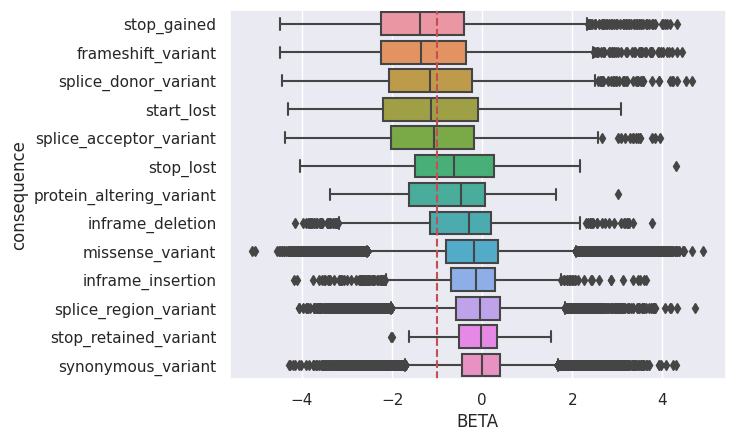

In [16]:
sns.set()
sns.boxplot(data=df, y='consequence', x='BETA')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

<Axes: xlabel='BETA', ylabel='ptv'>

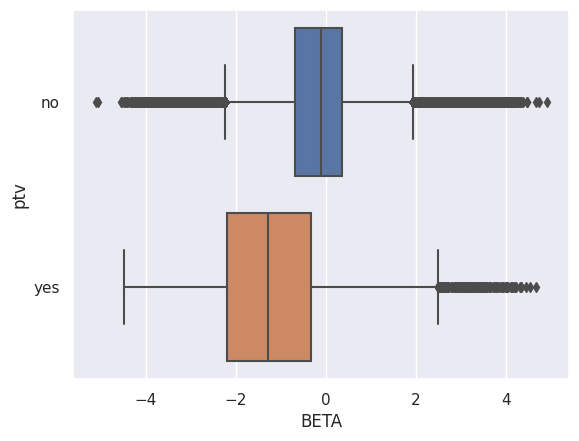

In [17]:
sns.boxplot(data=df, x='BETA', y='ptv')

In [18]:
# t-test between betas of PTVs and non-PTVs
stat, pval = stats.ttest_ind(df.loc[df['ptv']=="yes", 'BETA'], df.loc[df['ptv']=="no", 'BETA'], equal_var = False)
print(f"p-value: {pval}")
if pval < 0.05:
    print(f"There is a significant difference in effect size between predicted PTVs and non-PTVs")
else:
    print(f"There is not a significant difference in effect size between predicted PTVs and non-PTVs")

p-value: 0.0
There is a significant difference in effect size between predicted PTVs and non-PTVs


## Breakdown by chromosome

In [19]:
chr_grp = ptvs.groupby('CHROM')
chr_grp['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
CHROM,,,,,,,,
1,2106.0,-1.234810,1.323333,-4.48250,-2.232975,-1.317525,-0.336880,3.50463
2,1048.0,-1.255528,1.329473,-4.16093,-2.255822,-1.441740,-0.268055,3.62413
3,897.0,-1.461334,1.325031,-4.27724,-2.440430,-1.602920,-0.620672,4.65809
4,840.0,-1.246799,1.274262,-4.11062,-2.212620,-1.327715,-0.366811,3.50687
5,707.0,-1.368805,1.393355,-4.30994,-2.388880,-1.563430,-0.455568,3.57473
6,811.0,-1.208993,1.357525,-4.31760,-2.195320,-1.216440,-0.306601,4.04864
7,802.0,-1.148347,1.410121,-4.45087,-2.196605,-1.162725,-0.205147,4.01896
8,493.0,-1.203668,1.321547,-3.87070,-2.204450,-1.271760,-0.346200,3.42003
9,837.0,-1.336562,1.150397,-3.77903,-2.203660,-1.414470,-0.592744,3.92264


In [20]:
sorted_chr = chr_grp['BETA'].median().sort_values()
custom_order = sorted_chr.index.tolist()
ptvs['CHROM2'] = pd.Categorical(ptvs['CHROM'], categories=custom_order, ordered=True)

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='CHROM2'>

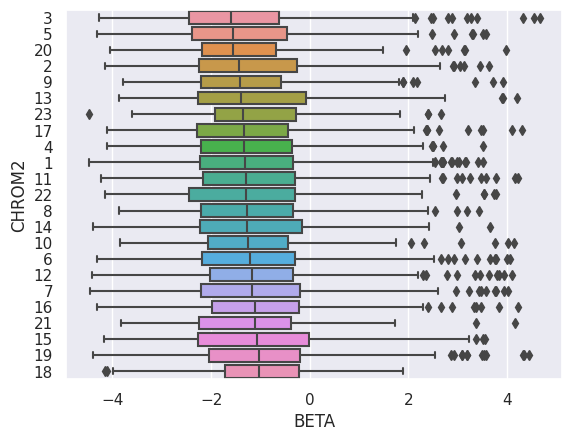

In [21]:
sns.boxplot(data=ptvs, x='BETA', y='CHROM2')

## Breakdown by genes with a given number of predicted PTVs

Breakdown by genes with a given number of PTVs
the N=5 means 5 or more until next category , so 5 to 9

In [22]:
ptvs['gene_cnt']=1

In [23]:
for gene in ptvs['symbol'].unique():
    if len(ptvs.loc[ptvs['symbol']==gene,:])==1:
        continue
    elif len(ptvs.loc[ptvs['symbol']==gene,:])==2:
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 2
    elif len(ptvs.loc[ptvs['symbol']==gene,:])==3:
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 3
    elif len(ptvs.loc[ptvs['symbol']==gene,:])==4:
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 4
    elif (len(ptvs.loc[ptvs['symbol']==gene,:])>=5)&(len(ptvs.loc[ptvs['symbol']==gene,:])<10):
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 5
    elif (len(ptvs.loc[ptvs['symbol']==gene,:])>=10)&(len(ptvs.loc[ptvs['symbol']==gene,:])<20):
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 10
    elif (len(ptvs.loc[ptvs['symbol']==gene,:])>=20)&(len(ptvs.loc[ptvs['symbol']==gene,:])<30):
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 20
    elif (len(ptvs.loc[ptvs['symbol']==gene,:])>=30)&(len(ptvs.loc[ptvs['symbol']==gene,:])<40):
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 30
    elif (len(ptvs.loc[ptvs['symbol']==gene,:])>=40)&(len(ptvs.loc[ptvs['symbol']==gene,:])<50):
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 40
    elif (len(ptvs.loc[ptvs['symbol']==gene,:])>=50)&(len(ptvs.loc[ptvs['symbol']==gene,:])<100):
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 50
    else:
        ptvs.loc[ptvs['symbol']==gene,'gene_cnt'] = 100

In [24]:
ptvs['gene_cnt'] = pd.Categorical(ptvs['gene_cnt'], ordered=True)

In [25]:
gene_cnt_grp = ptvs.groupby('gene_cnt')
gene_cnt_grp['BETA'].describe()

/var/tmp/ipykernel_130653/2393659338.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gene_cnt_grp = ptvs.groupby('gene_cnt')


,count,mean,std,min,25%,50%,75%,max
gene_cnt,,,,,,,,
1,97.0,-0.882303,1.147552,-4.48307,-1.664080,-0.654180,0.036567,0.888619
2,248.0,-1.036784,1.345676,-4.38666,-2.043992,-0.973969,-0.072274,4.536850
3,420.0,-1.131085,1.421484,-4.13490,-2.163505,-1.149125,-0.175870,3.703970
4,528.0,-1.208110,1.436294,-4.48250,-2.322002,-1.220070,-0.118285,3.624130
5,3595.0,-1.219886,1.371091,-4.40800,-2.220860,-1.292580,-0.275998,4.658090
10,6611.0,-1.285123,1.346064,-4.45087,-2.289255,-1.381030,-0.398034,4.443170
20,2806.0,-1.252184,1.247092,-4.25673,-2.155133,-1.360940,-0.500586,3.844930
30,1198.0,-1.135186,1.215419,-4.13427,-2.051722,-1.187135,-0.268504,4.048640
40,364.0,-1.079706,1.221365,-3.72461,-2.087675,-1.201115,-0.164089,3.151480


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='gene_cnt'>

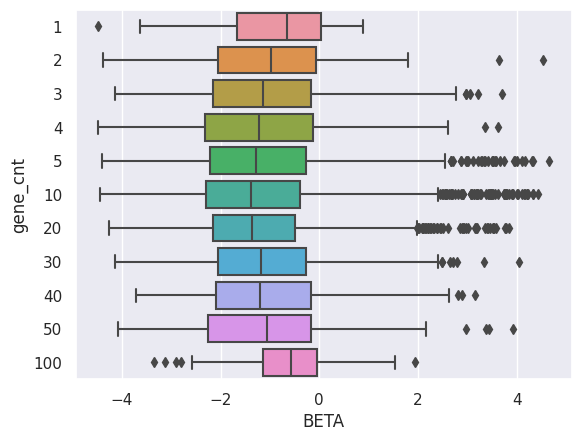

In [26]:
sns.boxplot(data=ptvs, x='BETA', y='gene_cnt')

# Allele Frequency

In [27]:
# read in saved PTVs dataframe
#ptvs = pd.read_csv('/home/jupyter/gcs/ukb/QC/ptvs_QC.txt', sep='\t')

In [4]:
# Encode loss of function (LoF) binary classification
# 1 if effect size (beta) ≤ 1
# 0 otherwise
ptvs['loss_of_function'] = [1 if i<=-1 else 0 for i in ptvs['BETA']]

In [5]:
# Minor allele counts
ptvs['N'] = ptvs['N'].astype(int)
ptvs['MAC'] = np.round(2*ptvs['A1FREQ']*ptvs['N'],0)
ptvs['MAC'] = ptvs.loc[:,'MAC'].astype(int)

In [6]:
# Allele frequency buckets
def freq_bins(cols):
    freq = cols[0]
    mac = cols[1]
    
    if mac == 1:
        return "singleton"
    elif mac == 2:
        return "doubleton"
    elif (mac > 2) & (freq < 0.0001):
        return "<0.01%"
    elif (freq >= 0.0001) & (freq < 0.001):
        return "0.01-0.1%"
    elif (freq >= 0.001) & (freq < 0.01):
        return "0.1-1%"
    elif (freq >= 0.01) & (freq < 0.1):
        return "1-10%"
    else:
        return ">10%"
    
ptvs['freq'] = ptvs[['A1FREQ','MAC']].apply(freq_bins,axis=1)

/var/tmp/ipykernel_7245/3449893086.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  freq = cols[0]
/var/tmp/ipykernel_7245/3449893086.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mac = cols[1]


In [7]:
# number of variants in each frequency bucket
custom_order = ['singleton','doubleton','<0.01%','0.01-0.1%',"0.1-1%","1-10%",">10%"]
ptvs['freq'] = pd.Categorical(ptvs['freq'], categories=custom_order, ordered=True)
freq_grp = ptvs.groupby('freq')
#freq_grp['ID'].count()

/var/tmp/ipykernel_7245/803634562.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_grp = ptvs.groupby('freq')


In [32]:
# types of PTVs assessed by LOFTEE
ptv_types = ['stop_gained', 'frameshift_variant', 'splice_acceptor_variant', 'splice_donor_variant']
# add column for binary classification of "yes" = PTV, "no" = not PTV
ptvs['loftee'] = ['yes' if i in ptv_types else 'no' for i in ptvs.loc[:,'consequence']]

In [170]:
loftee = ptvs.loc[pd.notna(ptvs['lof']), :]

In [34]:
# check if all predicted PTVs have LOFTEE annotations
a = len(ptvs.loc[ptvs['loftee']=='yes',:])
b = len(loftee)
print(f"Check: {a} = {b}")
if a>b:
    print(f"There are {a-b} predicted stop-gain/frameshift/splice PTVs without LOFTEE annotations:")
    print(ptvs.loc[(ptvs['loftee']=='yes')&(pd.isna(ptvs['lof'])), ['ID','BETA','lof']]) 

Check: 15804 = 15640
There are 164 predicted stop-gain/frameshift/splice PTVs without LOFTEE annotations:
                                            ID      BETA  lof
297                      1:21937195:G:GCGCCCGC -3.382880  NaN
298                      1:21937204:G:GCCCGCCA -3.022040  NaN
407    1:26941626:AAGAGGCAGAGAGGCTGCAGCTAGAG:A -2.142450  NaN
446                             1:35760885:C:A  1.646870  NaN
461                             1:37719908:C:T  0.252875  NaN
...                                        ...       ...  ...
16031                          22:20430479:G:T -2.789870  NaN
16203                          22:36265440:G:T -2.281030  NaN
16204                          22:36265665:C:T  0.205814  NaN
16205                         22:36265689:G:GC  1.467000  NaN
16206                          22:36265698:C:T  1.038610  NaN

[164 rows x 3 columns]


In [35]:
freq_grp = loftee.groupby('freq')
freq_grp['BETA'].describe()

/var/tmp/ipykernel_130653/981533572.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_grp = loftee.groupby('freq')


,count,mean,std,min,25%,50%,75%,max
freq,,,,,,,,
singleton,9974.0,-1.265270,1.415324,-4.48307,-2.332117,-1.369205,-0.338724,4.658090
doubleton,2242.0,-1.233664,1.231180,-3.91960,-2.155622,-1.289785,-0.384352,4.167590
<0.01%,2445.0,-1.150754,1.095747,-3.76718,-1.969840,-1.188620,-0.367823,3.776400
0.01-0.1%,799.0,-1.122209,0.991970,-3.13601,-1.841415,-1.176270,-0.340458,3.190490
0.1-1%,134.0,-0.872123,0.943198,-2.70554,-1.629923,-0.896942,-0.029215,1.977450
1-10%,34.0,-0.575731,0.715712,-1.87219,-1.164635,-0.357900,0.000497,0.795204
>10%,12.0,-0.684838,0.755084,-1.69499,-1.105253,-0.955090,-0.297664,1.120020


Text(0, 0.5, 'loss of function (%)')

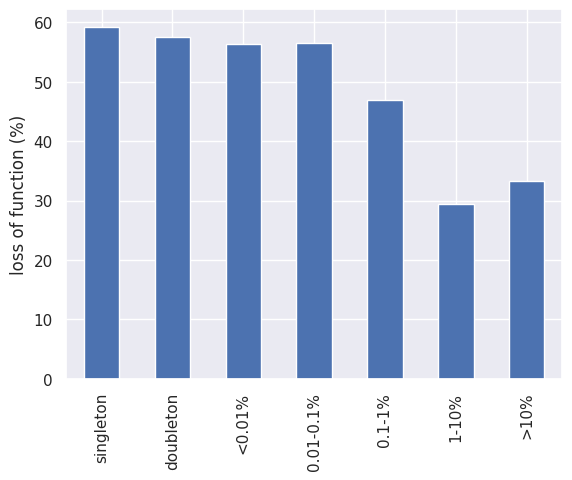

In [36]:
# plot percentage of each frequency bucket that is loss-of-function
(freq_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label

Text(0, 0.5, 'Percentage filtered LC by LOFTEE (%)')

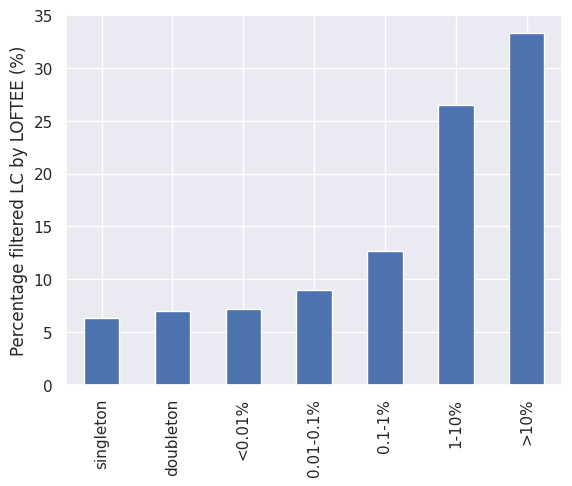

In [37]:
# plot percentage of each frequency bucket filtered (LC) by LOFTEE
(freq_grp['lof']
 .value_counts(normalize=True)
 .mul(100)
 [:,'LC'].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("Percentage filtered LC by LOFTEE (%)") ## Set Y-axis label

### Logistic regression

In [9]:
def assess_pred(truth, predicted):
    TP = sum((truth==1)&(predicted==1))
    TN = sum((truth==0)&(predicted==0))
    FP = sum((truth==0)&(predicted==1))
    FN = sum((truth==1)&(predicted==0))
    P = TP+FN
    N = FP+TN
    cm = pd.crosstab(truth, predicted)
    if (sum(predicted==1)==0):
        cm[1] = [0,0]
    elif (sum(predicted==0)==0):
        cm[0] = [0,0]
    cm = cm.reindex([1,0], axis=0)
    cm = cm.reindex([1,0], axis=1)
    OR, pval = stats.fisher_exact(cm, alternative='greater')
    if (sum(predicted==1)==0):
        precision = np.nan
        odds = np.nan
    elif (FP==0)|(FN==0):
        precision = TP/(TP+FP)
        odds = np.nan
    else:
        precision = TP/(TP+FP)
        odds = TP*TN/(FP*FN)
    recall = TP/P
    print(f"Total: {P+N}")
    print(f"Correct predictions (accuracy): {TP+TN} ({np.round(100*(TP+TN)/(P+N),1)}%)")
    print(f"TPR (recall/sensitivity)=TP/P: {np.round(100*recall,1)}%")
    print(f"TNR (specificity)=TN/N: {np.round(100*TN/N,1)}%")
    print(f"PPV (precision)=TP/(TP+FP): {np.round(100*precision,1)}%")
    print(f"FDR (false discovery)=1-PPV: {np.round(100*(1-precision),1)}%")
    print(f"FPR (false positive rate)=FP/N=1-TNR: {np.round(100*FP/N,1)}%")
    print(f"F1 score: {np.round(100*2*recall*precision/(precision+recall),1)}%")
    print(f"OR (odds ratio)=(TP/FP)/(FN/TN): {np.round(odds,2)}")
    print(f"Fisher exact test p-value: {pval}")

In [10]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - stats.norm.cdf(abs(t))) * 2
    d = {'Estimate':coefs,
         'Std_Error':se,
         'z_val':t,
         'p_val':p}
    return d

In [130]:
# Dummy variables for allele frequency buckets
freq = pd.get_dummies(loftee['freq'], drop_first=False)
X = freq.drop('singleton', axis=1)

In [131]:
# logistic regression model of loss of function classification vs. allele frequency buckets
#X = freq
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

           Estimate  Std_Error      z_val     p_val
intercept  0.373810   0.020377  18.344825  0.000000
doubleton -0.071240   0.047334  -1.505066  0.132307
<0.01%    -0.115148   0.045593  -2.525562  0.011551
0.01-0.1% -0.121520   0.074173  -1.638346  0.101350
0.1-1%    -0.466259   0.174155  -2.677274  0.007422
>10%      -0.547923   0.579898  -0.944862  0.344729
1-10%     -1.158924   0.370327  -3.129457  0.001751


col_0               0      1    All
loss_of_function                   
0                 103   6429   6532
1                  77   9031   9108
All               180  15460  15640

Evaluation metrics with threshold 0.5:
Total: 15640
Correct predictions (accuracy): 9134 (58.4%)
TPR (recall/sensitivity)=TP/P: 99.2%
TNR (specificity)=TN/N: 1.6%
PPV (precision)=TP/(TP+FP): 58.4%
FDR (false discovery)=1-PPV: 41.6%
FPR (false positive rate)=FP/N=1-TNR: 98.4%
F1 score: 73.5%
OR (odds ratio)=(TP/FP)/(FN/TN): 1.88
Fisher exact test p-value: 1.9071878291294796e-05


intercept/reference = singletons.  
As expected, coef decreases with increasing frequency (more likely not LoF).  
singleton (intercept), <0.01%, 0.1-1%, 1-10% are statistically significant (p<0.05).  
doubleton, 0.01-0.1%, >10% are not.

Area Under the ROC Curve: 0.515204924386978


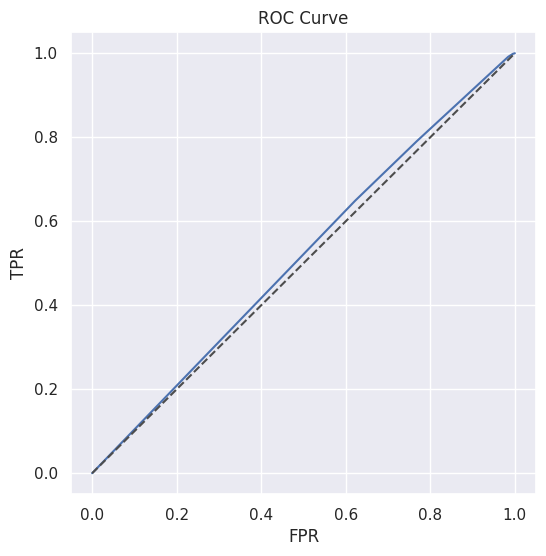

In [42]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [43]:
def optimal_threshold(y_true, y_prob):
    '''
    Find the optimal logistic regression threshold
    that maximizes distance between TPR and FPR.

    Args:
    y_true: A numpy array of true labels.
    y_prob: A numpy array of predicted probabilities.

    Returns:
    The optimal threshold.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    # Find the threshold that maximizes AUC.
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

In [44]:
opt_thresh = optimal_threshold(y, y_scores)
print(opt_thresh)

0.5923792721299614


In [45]:
pred = (model.predict_proba(X)[:,1]>=opt_thresh).astype(int)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for optimized threshold 
print(f"\nEvaluation metrics with optimized threshold: {np.round(opt_thresh,3)}") 
assess_pred(y, pred)

col_0                0     1    All
loss_of_function                   
0                 2468  4064   6532
1                 3198  5910   9108
All               5666  9974  15640

Evaluation metrics with optimized threshold: 0.592
Total: 15640
Correct predictions (accuracy): 8378 (53.6%)
TPR (recall/sensitivity)=TP/P: 64.9%
TNR (specificity)=TN/N: 37.8%
PPV (precision)=TP/(TP+FP): 59.3%
FDR (false discovery)=1-PPV: 40.7%
FPR (false positive rate)=FP/N=1-TNR: 62.2%
F1 score: 61.9%
OR (odds ratio)=(TP/FP)/(FN/TN): 1.12
Fisher exact test p-value: 0.0003268273030340495


### Frequency breakdown by predicted consequence

In [46]:
frq_cons = ptvs.groupby(['consequence','freq'])
frq_cons['BETA'].describe()

/var/tmp/ipykernel_130653/768667769.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frq_cons = ptvs.groupby(['consequence','freq'])


count      mean       std       min  \
consequence             freq                                              
frameshift_variant      singleton  4251.0 -1.327819  1.381592 -4.482500   
                        doubleton   919.0 -1.270108  1.202382 -3.811540   
                        <0.01%     1041.0 -1.166106  1.127808 -3.767180   
                        0.01-0.1%   341.0 -1.174687  1.050712 -3.136010   
                        0.1-1%       58.0 -1.048191  0.878350 -2.705540   
                        1-10%        13.0 -0.422148  0.698559 -1.455880   
                        >10%          2.0 -0.287485  1.990513 -1.694990   
splice_acceptor_variant singleton  1049.0 -1.123256  1.411992 -4.386660   
                        doubleton   192.0 -0.992847  1.254373 -3.870700   
                        <0.01%      227.0 -1.066148  1.026770 -3.637300   
                        0.01-0.1%    71.0 -0.760191  0.901974 -2.496940   
                        0.1-1%       18.0 -0.669624  0.903561 -2.499070   
                        1-10%         2.0 -0.102387  0.190904 -0.237377   
                        >10%          1.0 -0.436045       NaN -0.436045   
splice_donor_variant    singleton  1330.0 -1.107930  1.498487 -4.450870   
                        doubleton   335.0 -1.141049  1.273175 -3.648080   
                        <0.01%      354.0 -1.033838  1.079975 -3.616670   
                        0.01-0.1%   120.0 -1.038572  1.021996 -2.863520   
                        0.1-1%       20.0 -0.795263  0.938868 -2.398460   
                        1-10%         4.0 -0.278402  0.377357 -0.798516   
                        >10%          2.0 -0.609028  0.500853 -0.963185   
start_lost              singleton   340.0 -1.118579  1.385075 -4.321580   
                        doubleton    71.0 -1.306687  1.228815 -3.720040   
                        <0.01%       68.0 -1.067819  1.126673 -3.045560   
                        0.01-0.1%    35.0 -0.990601  1.328572 -2.921700   
                        0.1-1%        4.0 -0.295024  0.353852 -0.769600   
                        1-10%         6.0 -0.487583  0.579413 -1.497330   
                        >10%          1.0  0.012257       NaN  0.012257   
stop_gained             singleton  3440.0 -1.299690  1.420506 -4.483070   
                        doubleton   820.0 -1.281052  1.240808 -3.919600   
                        <0.01%      856.0 -1.210362  1.078042 -3.719770   
                        0.01-0.1%   277.0 -1.198000  0.912434 -2.943280   
                        0.1-1%       38.0 -0.739761  1.044900 -2.180250   
                        1-10%        16.0 -0.847942  0.745666 -1.872190   
                        >10%          7.0 -0.855570  0.494209 -1.470160   
stop_lost               singleton   129.0 -0.644579  1.419370 -4.049820   
                        doubleton    27.0 -0.993877  1.022574 -2.828850   
                        <0.01%       39.0 -0.380514  1.017075 -2.370430   
                        0.01-0.1%    14.0 -0.442710  0.840597 -2.357830   
                        0.1-1%        4.0  0.016679  0.519080 -0.387019   
                        1-10%         2.0 -0.653080  0.518224 -1.019520   

                                        25%       50%       75%       max  
consequence             freq                                               
frameshift_variant      singleton -2.377135 -1.438200 -0.392941  4.443170  
                        doubleton -2.165900 -1.305340 -0.409505  4.143190  
                        <0.01%    -2.036660 -1.192660 -0.320390  3.765180  
                        0.01-0.1% -1.938060 -1.249830 -0.288585  3.084320  
                        0.1-1%    -1.729648 -1.141410 -0.116718  0.409574  
                        1-10%     -0.980187 -0.216668  0.017340  0.795204  
                        >10%      -0.991237 -0.287485  0.416268  1.120020  
splice_acceptor_variant singleton -2.180060 -1.156900 -0.171905  3.939270  
                        doubleton -1.833715 -0.891

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, 'All predicted PTVs')

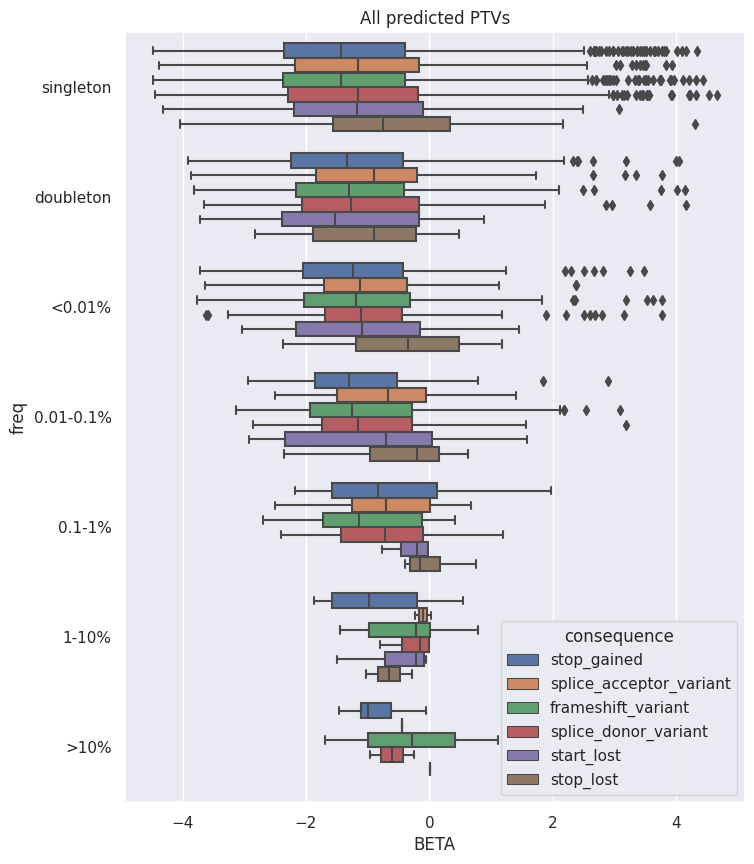

In [47]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=ptvs, x='BETA', y='freq', hue='consequence')
ax.set_title("All predicted PTVs")

In [91]:
cons_grp = ptvs.groupby('consequence')
cons_grp['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
frameshift_variant,6625.0,-1.281982,1.302245,-4.48250,-2.254040,-1.359220,-0.363577,4.44317
splice_acceptor_variant,1560.0,-1.075388,1.319690,-4.38666,-2.023285,-1.066630,-0.181718,3.93927
splice_donor_variant,2165.0,-1.092214,1.374212,-4.45087,-2.062690,-1.161370,-0.228726,4.65809
start_lost,525.0,-1.113272,1.319836,-4.32158,-2.210350,-1.135700,-0.089917,3.07898
stop_gained,5454.0,-1.271907,1.319649,-4.48307,-2.238700,-1.373290,-0.412211,4.33595
stop_lost,215.0,-0.615176,1.265606,-4.04982,-1.495050,-0.631455,0.256296,4.30413


Text(0, 0.5, 'loss of function (%)')

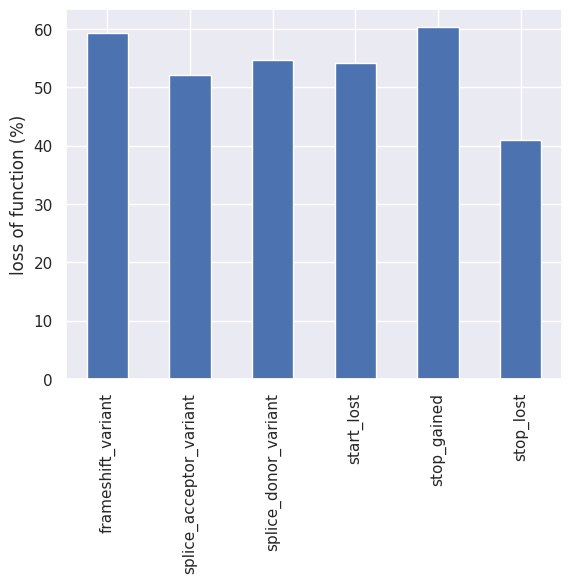

In [92]:
# plot percentage of each frequency bucket that is loss-of-function
(cons_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label

In [97]:
# Dummy variables for allele frequency buckets
cons = pd.get_dummies(ptvs['consequence'], drop_first=False)
X = cons.drop("stop_gained", axis=1)

In [98]:
# logistic regression model of loss of function classification vs. allele frequency buckets
y = ptvs['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                         Estimate  Std_Error      z_val         p_val
intercept                0.418755   0.027677  15.129913  0.000000e+00
frameshift_variant      -0.045826   0.037297  -1.228690  2.191880e-01
splice_donor_variant    -0.234132   0.051278  -4.565965  4.972012e-06
start_lost              -0.253034   0.091856  -2.754684  5.874881e-03
splice_acceptor_variant -0.329537   0.057752  -5.706114  1.155843e-08
stop_lost               -0.770700   0.141254  -5.456120  4.866524e-08


col_0               0      1    All
loss_of_function                   
0                 127   6835   6962
1                  88   9494   9582
All               215  16329  16544

Evaluation metrics with threshold 0.5:
Total: 16544
Correct predictions (accuracy): 9621 (58.2%)
TPR (recall/sensitivity)=TP/P: 99.1%
TNR (specificity)=TN/N: 1.8%
PPV (precision)=TP/(TP+FP): 58.1%
FDR (false discovery)=1-PPV: 41.9%
FPR (false positive rate)=FP/N=1-TNR: 98.2%
F1 score: 73.3%
OR (odds ratio)=(TP/FP)/(FN/TN): 2.

Area Under the ROC Curve: 0.531730387958702


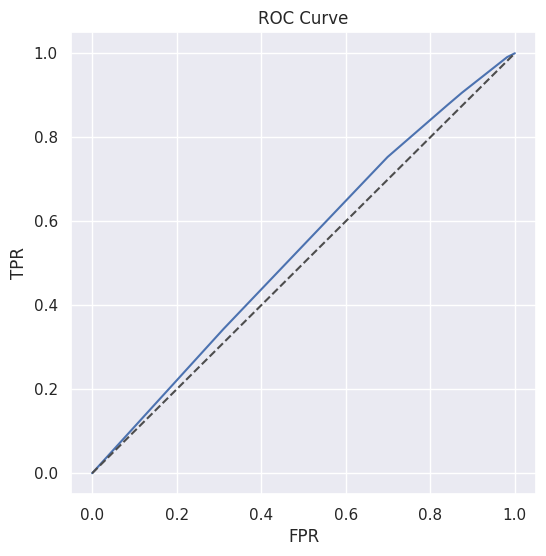

In [99]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [141]:
# Dummy variables for allele frequency buckets
cons2 = pd.get_dummies(loftee['consequence'], drop_first=False)
X = cons2.drop("stop_gained", axis=1)

In [142]:
# logistic regression model of loss of function classification vs. allele frequency buckets
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                         Estimate  Std_Error      z_val         p_val
intercept                0.420198   0.027830  15.098882  0.000000e+00
frameshift_variant      -0.048869   0.037491  -1.303475  1.924126e-01
splice_donor_variant    -0.240036   0.051590  -4.652775  3.274974e-06
splice_acceptor_variant -0.336365   0.057992  -5.800248  6.621679e-09


col_0                 1    All
loss_of_function              
0                  6532   6532
1                  9108   9108
All               15640  15640

Evaluation metrics with threshold 0.5:
Total: 15640
Correct predictions (accuracy): 9108 (58.2%)
TPR (recall/sensitivity)=TP/P: 100.0%
TNR (specificity)=TN/N: 0.0%
PPV (precision)=TP/(TP+FP): 58.2%
FDR (false discovery)=1-PPV: 41.8%
FPR (false positive rate)=FP/N=1-TNR: 100.0%
F1 score: 73.6%
OR (odds ratio)=(TP/FP)/(FN/TN): nan
Fisher exact test p-value: 1.0


Area Under the ROC Curve: 0.5273342416012947


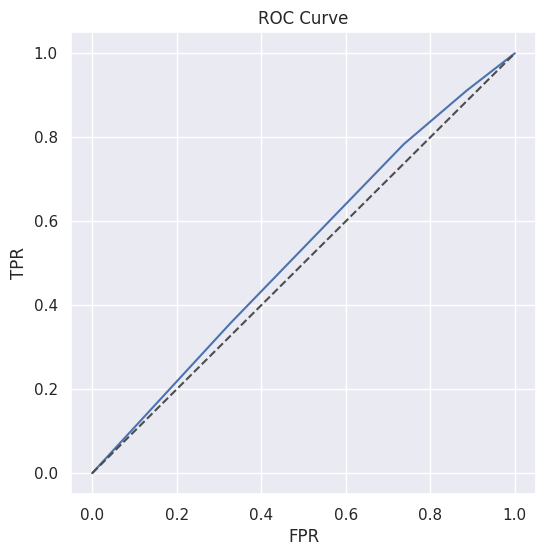

In [143]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [144]:
# combine predicted consequence and frequency
loftee['cons_freq'] = loftee['consequence'].astype(str) + "," + loftee['freq'].astype(str)

/var/tmp/ipykernel_130653/372197688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['cons_freq'] = loftee['consequence'].astype(str) + "," + loftee['freq'].astype(str)


In [145]:
# Dummy variables for allele frequency buckets
cons3 = pd.get_dummies(loftee['cons_freq'], drop_first=False)
X = cons3.drop("stop_gained,singleton", axis=1)

In [146]:
# logistic regression model of loss of function classification vs. allele frequency buckets
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                                   Estimate  Std_Error      z_val     p_val
intercept                          0.459390   0.035157  13.066871  0.000000
stop_gained,0.01-0.1%              0.007281   0.129450   0.056243  0.955148
frameshift_variant,singleton      -0.040464   0.047206  -0.857174  0.391349
stop_gained,doubleton             -0.070144   0.079773  -0.879299  0.379239
frameshift_variant,>10%           -0.093583   1.438365  -0.065062  0.948125
frameshift_variant,doubleton      -0.128730   0.075880  -1.696483  0.089794
frameshift_variant,0.01-0.1%      -0.171782   0.115398  -1.488603  0.136592
stop_gained,<0.01%                -0.178568   0.077943  -2.291004  0.021963
frameshift_variant,<0.01%         -0.192411   0.072062  -2.670065  0.007584
splice_donor_variant,doubleton    -0.198032   0.115993  -1.707278  0.087770
frameshift_variant,0.1-1%         -0.210928   0.266967  -0.790092  0.429474
splice_donor_variant,<0.01%       -0.229367   0.113356  -2.023423  0.043030
splice_donor

Area Under the ROC Curve: 0.5372666197102417


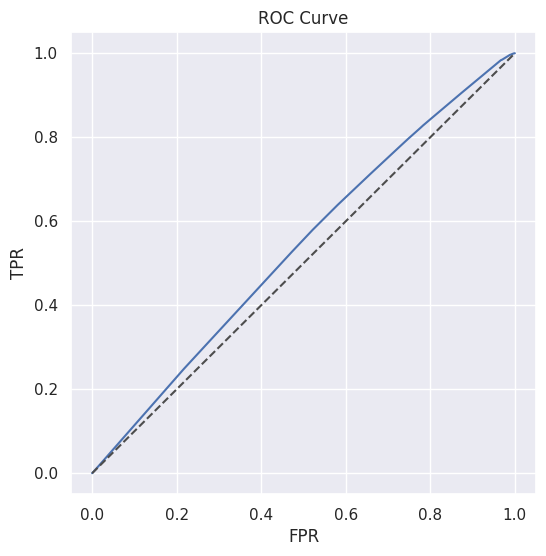

In [147]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [149]:
# combine predicted consequence and frequency
loftee['conf_cons_freq'] = loftee['lof'].astype(str) + "," + loftee['consequence'].astype(str) + "," + loftee['freq'].astype(str)

/var/tmp/ipykernel_130653/2569812331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['conf_cons_freq'] = loftee['lof'].astype(str) + "," + loftee['consequence'].astype(str) + "," + loftee['freq'].astype(str)


In [150]:
# Dummy variables for allele frequency buckets
ccf= pd.get_dummies(loftee['conf_cons_freq'], drop_first=False)
X = ccf.drop("HC,stop_gained,singleton", axis=1)

In [151]:
# logistic regression model of loss of function classification vs. allele frequency buckets
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                                      Estimate  Std_Error      z_val     p_val
intercept                             0.469000   0.036526  12.840017  0.000000
HC,stop_gained,0.01-0.1%              0.033384   0.138922   0.240304  0.810094
HC,frameshift_variant,singleton      -0.024012   0.049132  -0.488723  0.625038
HC,stop_gained,doubleton             -0.058861   0.082770  -0.711143  0.476996
HC,frameshift_variant,doubleton      -0.077431   0.080049  -0.967295  0.333396
LC,stop_gained,>10%                  -0.101479   1.438622  -0.070539  0.943765
HC,frameshift_variant,>10%           -0.101479   1.438622  -0.070539  0.943765
LC,splice_donor_variant,<0.01%       -0.101479   1.438622  -0.070539  0.943765
HC,stop_gained,1-10%                 -0.103671   0.588144  -0.176269  0.860083
HC,frameshift_variant,0.1-1%         -0.157510   0.291484  -0.540372  0.588941
HC,stop_gained,<0.01%                -0.158296   0.081580  -1.940362  0.052336
HC,frameshift_variant,<0.01%         -0.162475   0.0

Area Under the ROC Curve: 0.5461622955640701


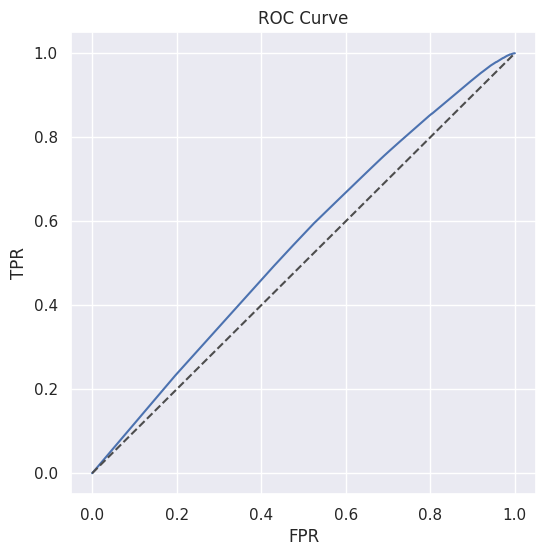

In [152]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [48]:
# predicted PTVs with LOFTEE high confidence (HC) annotation only
HC = loftee.loc[loftee['lof']=="HC", :]
LC = loftee.loc[loftee['lof']=="LC", :]
frq_cons = HC.groupby(['consequence','freq'])
frq_cons['BETA'].describe()

/var/tmp/ipykernel_130653/3485331547.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  frq_cons = HC.groupby(['consequence','freq'])


count      mean       std       min  \
consequence             freq                                              
frameshift_variant      singleton  3891.0 -1.354800  1.368959 -4.482500   
                        doubleton   819.0 -1.325999  1.154907 -3.811540   
                        <0.01%      939.0 -1.182604  1.118296 -3.767180   
                        0.01-0.1%   310.0 -1.186185  1.016398 -3.136010   
                        0.1-1%       49.0 -1.117490  0.867009 -2.705540   
                        1-10%         8.0 -0.545896  0.638089 -1.455880   
                        >10%          2.0 -0.287485  1.990513 -1.694990   
splice_acceptor_variant singleton  1000.0 -1.141731  1.417517 -4.386660   
                        doubleton   186.0 -0.997858  1.268642 -3.870700   
                        <0.01%      214.0 -1.088686  1.033183 -3.637300   
                        0.01-0.1%    62.0 -0.807446  0.930024 -2.496940   
                        0.1-1%       16.0 -0.748695  0.929712 -2.499070   
                        1-10%         2.0 -0.102387  0.190904 -0.237377   
splice_donor_variant    singleton  1289.0 -1.106258  1.491860 -4.220190   
                        doubleton   325.0 -1.165543  1.269187 -3.648080   
                        <0.01%      347.0 -1.029075  1.078334 -3.616670   
                        0.01-0.1%   118.0 -1.059007  1.018296 -2.863520   
                        0.1-1%       18.0 -0.955401  0.823708 -2.398460   
                        1-10%         3.0 -0.105031  0.182351 -0.315578   
                        >10%          1.0 -0.254872       NaN -0.254872   
stop_gained             singleton  3166.0 -1.332876  1.405976 -4.483070   
                        doubleton   756.0 -1.319794  1.185043 -3.919600   
                        <0.01%      770.0 -1.232756  1.049024 -3.697230   
                        0.01-0.1%   237.0 -1.215498  0.911832 -2.943280   
                        0.1-1%       34.0 -0.779195  1.043971 -2.180250   
                        1-10%        12.0 -0.952646  0.784302 -1.872190   
                        >10%          5.0 -0.786536  0.584997 -1.470160   

                                        25%       50%       75%       max  
consequence             freq                                               
frameshift_variant      singleton -2.394320 -1.464410 -0.429524  4.443170  
                        doubleton -2.209740 -1.364550 -0.464943  3.763550  
                        <0.01%    -2.036015 -1.216250 -0.336607  3.765180  
                        0.01-0.1% -1.909707 -1.239300 -0.295669  3.084320  
                        0.1-1%    -1.812720 -1.162660 -0.210315  0.290816  
                        1-10%     -0.981903 -0.585346 -0.154460  0.421029  
                        >10%      -0.991237 -0.287485  0.416268  1.120020  
splice_acceptor_variant singleton -2.189233 -1.201040 -0.195260  3.939270  
                        doubleton -1.833885 -0.896728 -0.190420  3.780780  
                        <0.01%    -1.745765 -1.165075 -0.388297  2.380770  
                        0.01-0.1% -1.620092 -0.709145 -0.071960  1.410380  
                        0.1-1%    -1.432135 -0.772343 -0.015119  0.678402  
                        1-10%     -0.169882 -0.102387 -0.034892  0.032603  
splice_donor_variant    singleton -2.291330 -1.151250 -0.196413  4.658090  
                        doubleton -2.107900 -1.294240 -0.201204  4.167590  
                        <0.01%    -1.686245 -1.110480 -0.445340  3.776400  
                        0.01-0.1% -1.755672 -1.165645 -0.329597  3.190490  
                        0.1-1%    -1.702345 -0.997358 -0.197912  0.201661  
                        1-10%     -0.158719 -0.001860  0.000242  0.002344  
                        >10%      -0.254872 -0.254872 -0.254872 -0.254872  
stop_gained             singleton -2.387310 -1.449540 -0.445159  4.335950  
                        doubleton -2.235265 -1.354485 -0.479019  3.186080  
                        <0.01%    -2

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, 'LOFTEE High Confidence Only')

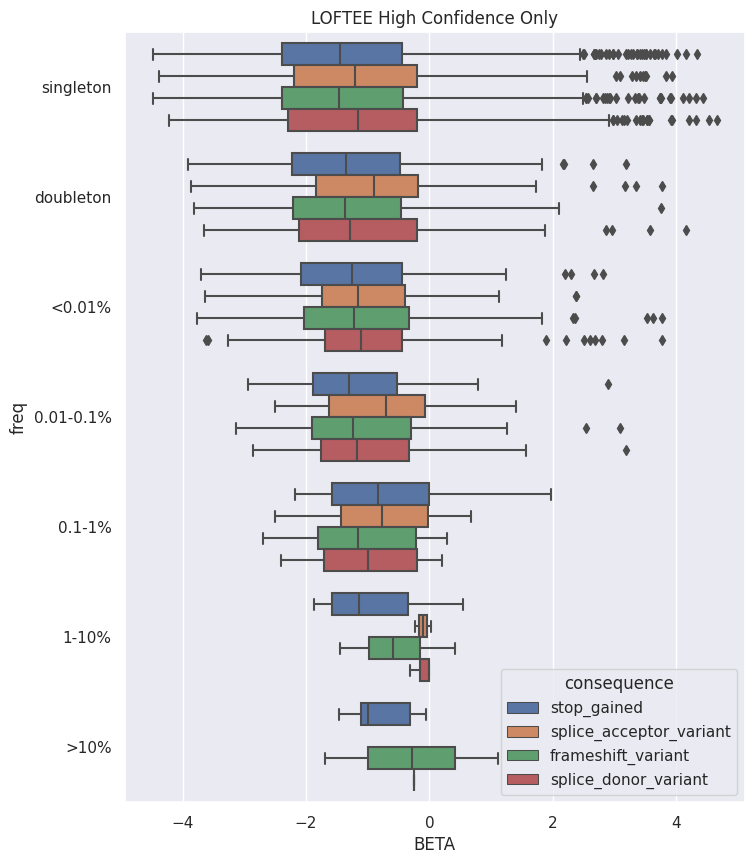

In [49]:
f, ax = plt.subplots(figsize=(8, 10))
sns.boxplot(data=HC, x='BETA', y='freq', hue='consequence')
ax.set_title("LOFTEE High Confidence Only")

# Analysis of LOFTEE annotations

## LOFTEE Confidence

### HC vs. LC

Currently assesses variants that are:

- Stop-gained
- Splice site disrupting
- Frameshift variants

LOFTEE implements a set of filters to deem a LoF as "low-confidence" (LC). Variants that pass these filters are labeled as "high-confidence" (HC).

HC refers to high-confidence LoF variants (i.e. does not fail any filters). LC denotes low-confidence, failing at least one filter, which are written to the LoF_filter field.

In [156]:
conf_grp = loftee.groupby('lof')
conf_grp['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
lof,,,,,,,,
HC,14579.0,-1.256557,1.310616,-4.48307,-2.22457,-1.323310,-0.371453,4.65809
LC,1061.0,-0.868260,1.413482,-4.40800,-1.94289,-0.955866,0.050514,4.14319


In [154]:
len(loftee.loc[loftee['lof']=='HC',:])/len(loftee)*100

93.21611253196932

<Axes: xlabel='BETA', ylabel='lof'>

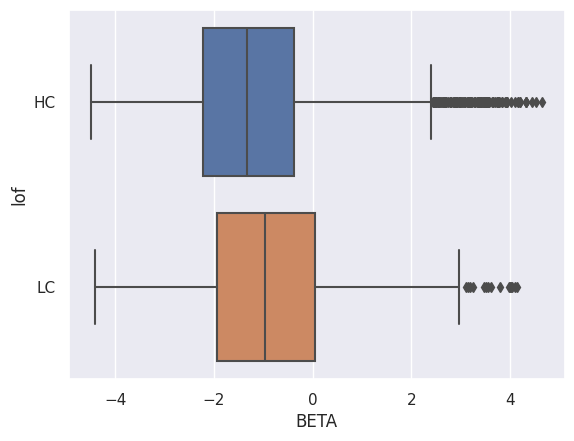

In [155]:
sns.set()
sns.boxplot(data=loftee, y='lof', x='BETA')

Text(0, 0.5, 'loss of function (%)')

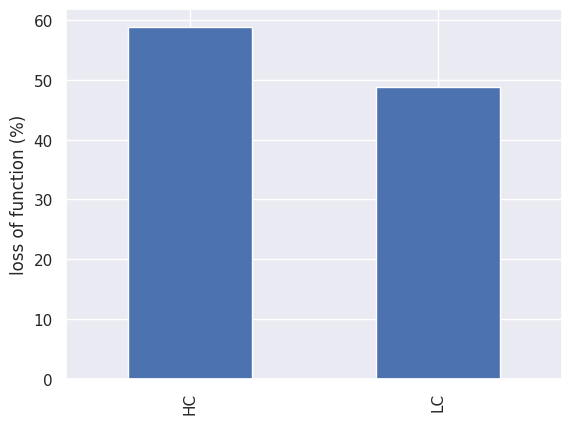

In [157]:
# plot percentage of each frequency bucket that is loss-of-function
(conf_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

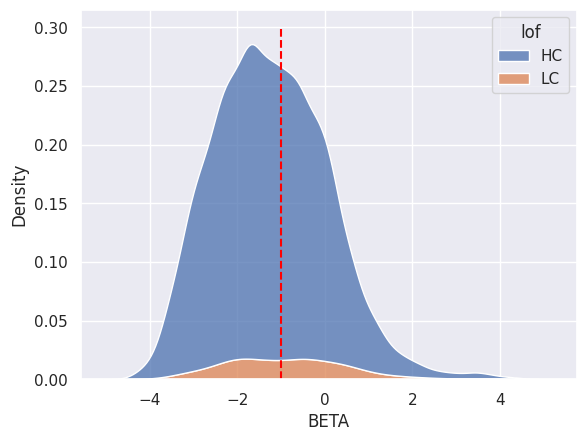

In [51]:
ax = sns.kdeplot(data=loftee, x="BETA", hue="lof", multiple="stack")
ax.vlines(x=-1, ymin=0, ymax=0.3, linestyles="dashed", colors="red") 

In [11]:
# t-test between effect size of LOFTEE high-confidence vs. low-confidence PTVs
HC = loftee.loc[loftee['lof']=="HC", :]
LC = loftee.loc[loftee['lof']=="LC", :]
stat, pval = stats.ttest_ind(loftee.loc[loftee['lof']=="HC", 'BETA'], loftee.loc[loftee['lof']=="LC", 'BETA'], equal_var = False)
print(f"HC vs. LC PTV p-value: {pval}")

HC vs. LC PTV p-value: 1.2668277752974386e-17


There is a significant difference in beta between the HC and LC groups

In [53]:
loftee.groupby(['lof','freq'], observed=True).describe()['BETA']

count      mean       std      min       25%       50%  \
lof freq                                                                 
HC  singleton  9346.0 -1.290296  1.407317 -4.48307 -2.355545 -1.392645   
    doubleton  2086.0 -1.269492  1.198069 -3.91960 -2.172778 -1.305960   
    <0.01%     2270.0 -1.167293  1.082834 -3.76718 -1.977255 -1.204175   
    0.01-0.1%   727.0 -1.142799  0.981338 -3.13601 -1.846905 -1.187030   
    0.1-1%      117.0 -0.943812  0.926425 -2.70554 -1.654610 -0.997468   
    1-10%        25.0 -0.652751  0.718675 -1.87219 -1.261380 -0.400221   
    >10%          8.0 -0.595315  0.911770 -1.69499 -1.195465 -0.651366   
LC  singleton   628.0 -0.892821  1.481529 -4.40800 -1.999567 -1.027030   
    doubleton   156.0 -0.754581  1.535995 -3.42763 -1.971805 -0.722068   
    <0.01%      175.0 -0.936214  1.234726 -3.71977 -1.850340 -0.937232   
    0.01-0.1%    72.0 -0.914312  1.078989 -2.58993 -1.731367 -0.939345   
    0.1-1%       17.0 -0.378735  0.936137 -2.22767 -1.184080  0.037658   
    1-10%         9.0 -0.361786  0.702489 -1.32997 -0.875584 -0.187246   
    >10%          4.0 -0.863884  0.294419 -1.10931 -0.999716 -0.955090   

                    75%       max  
lof freq                           
HC  singleton -0.368911  4.658090  
    doubleton -0.408515  4.167590  
    <0.01%    -0.392612  3.776400  
    0.01-0.1% -0.356298  3.190490  
    0.1-1%    -0.136065  1.977450  
    1-10%     -0.001860  0.545427  
    >10%      -0.205126  1.120020  
LC  singleton  0.133773  4.102190  
    doubleton  0.264634  4.143190  
    <0.01%    -0.097717  3.479570  
    0.01-0.1% -0.255386  2.190120  
    0.1-1%     0.099335  1.192620  
    1-10%      0.001283  0.795204  
    >10%      -0.819258 -0.436045

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='BETA', ylabel='freq'>

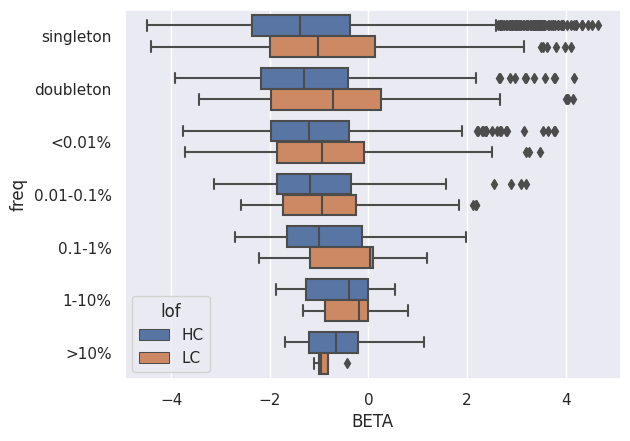

In [54]:
sns.boxplot(data=loftee, y='freq', x='BETA', hue='lof')

Text(0.5, 1.0, 'LOFTEE HC pLoFs')

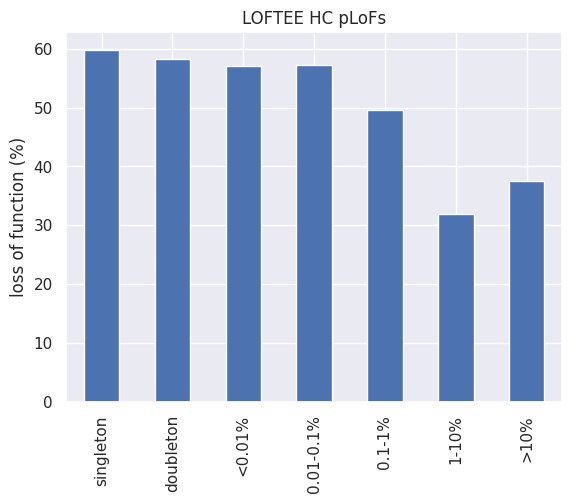

In [22]:
HC_freq = HC.groupby(['freq'], observed=True)
(HC_freq['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
plt.title('LOFTEE HC pLoFs')

Text(0.5, 1.0, 'All pLoFs')

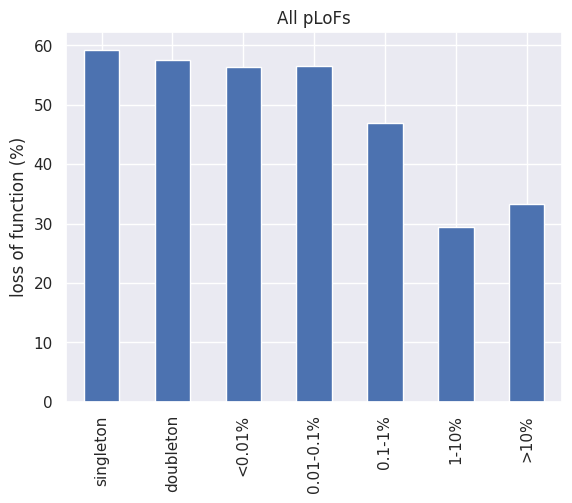

In [26]:
all_freq = loftee.groupby(['freq'], observed=True)
(all_freq['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
plt.title('All pLoFs')

In [28]:
len(loftee.loc[loftee['A1FREQ']>=0.1,:])/len(loftee)*100

0.07672634271099744

In [55]:
# Performing two-way ANOVA to assess interaction term between frequency bucket and LOFTEE confidence
model = ols('BETA ~ C(lof) + C(freq) + C(lof):C(freq)', 
            data=loftee).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result) 

                     df        sum_sq     mean_sq          F        PR(>F)
C(lof)              1.0    149.119349  149.119349  86.026240  2.003425e-20
C(freq)             6.0     62.681369   10.446895   6.026764  2.608463e-06
C(lof):C(freq)      6.0      9.596431    1.599405   0.922689  4.771328e-01
Residual        15626.0  27086.374482    1.733417        NaN           NaN


The interaction term is not significant - the relationship between LOFTEE confidence and Beta is not dependent on allele frequency.

In [56]:
# Binary dummy variable for LOFTEE confidence
lof = pd.get_dummies(loftee['lof'], drop_first=True)

In [57]:
# logistic regression model of loss of function classification vs. LOFTEE confidence
X = lof
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
print(pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist()))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

           Estimate  Std_Error      z_val         p_val
intercept  0.360631   0.016834  21.422717  0.000000e+00
LC        -0.406194   0.063682  -6.378503  1.788276e-10


col_0                0      1    All
loss_of_function                    
0                  543   5989   6532
1                  518   8590   9108
All               1061  14579  15640

Evaluation metrics with threshold 0.5:
Total: 15640
Correct predictions (accuracy): 9133 (58.4%)
TPR (recall/sensitivity)=TP/P: 94.3%
TNR (specificity)=TN/N: 8.3%
PPV (precision)=TP/(TP+FP): 58.9%
FDR (false discovery)=1-PPV: 41.1%
FPR (false positive rate)=FP/N=1-TNR: 91.7%
F1 score: 72.5%
OR (odds ratio)=(TP/FP)/(FN/TN): 1.5
Fisher exact test p-value: 9.804323764767846e-11


Area Under the ROC Curve: 0.5131280657153284


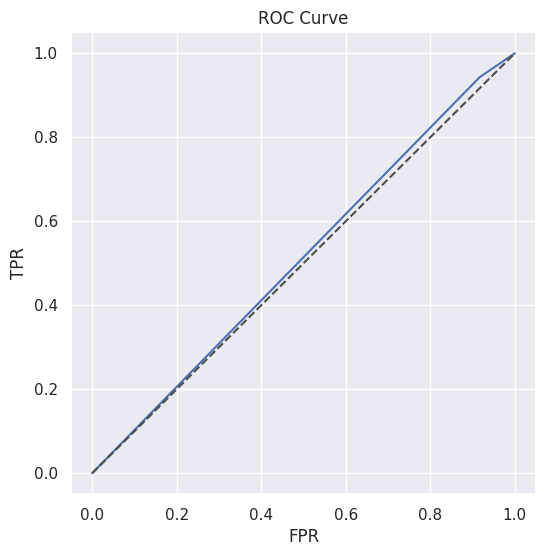

In [58]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [59]:
opt_thresh = optimal_threshold(y, y_scores)
print(opt_thresh)

0.589193163853343


In [60]:
pred = (model.predict_proba(X)[:,1]>=opt_thresh).astype(int)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for optimized threshold 
print(f"\nEvaluation metrics with optimized threshold: {np.round(opt_thresh,3)}") 
assess_pred(y, pred)

col_0                0      1    All
loss_of_function                    
0                  543   5989   6532
1                  518   8590   9108
All               1061  14579  15640

Evaluation metrics with optimized threshold: 0.589
Total: 15640
Correct predictions (accuracy): 9133 (58.4%)
TPR (recall/sensitivity)=TP/P: 94.3%
TNR (specificity)=TN/N: 8.3%
PPV (precision)=TP/(TP+FP): 58.9%
FDR (false discovery)=1-PPV: 41.1%
FPR (false positive rate)=FP/N=1-TNR: 91.7%
F1 score: 72.5%
OR (odds ratio)=(TP/FP)/(FN/TN): 1.5
Fisher exact test p-value: 9.804323764767846e-11


## LOFTEE Filters

For stop-gained and frameshift variants, LOFTEE removes:

Variants that are near the end of the transcript (based on the 50 bp rule, with modifications as described in Karczewski et al., 2019 supplement)  
Variants that land in an exon with non-canonical splice sites around it (i.e. intron does not start with GT and end with AG)  

For splice-site variants, LOFTEE removes:

Variants that only affect splicing of UTRs  
Variants that are not predicted to affect a donor site (GC -> GT)  
Variants where MaxEntScan does not predict an effect on splicing  
Variants that are "rescued" by nearby, in-frame splice sites (max_scan_distance determines distance from original splice site where rescue splice sites can occur; default = 15 bp)  
Variants in small introns (min_intron_size; default = 15 bp; only relevant to older versions of Gencode)  

For all variants, LOFTEE removes:

Variants where the purported LoF allele is the ancestral state (across primates)  
Variants in incomplete transcripts (only relevant to older versions of Gencode)  

Possible values for the LoF_filter field are:

END_TRUNC The LoF variant falls in the last filter_position of the transcript (default = 0.05).

INCOMPLETE_CDS The LoF falls in a transcript whose start or stop codons are not known.

EXON_INTRON_UNDEF The LoF falls in a transcript whose exon/intron boundaries are undefined in the EnsEMBL API.

SMALL_INTRON The LoF falls in a splice site of a small (biologically unlikely; default < 15 bp) intron.

ANC_ALLELE The alternate allele of the LoF reverts the sequence back to the ancestral state.

NON_DONOR_DISRUPTING An essential splice donor variant’s DISRUPTION_PROB fails to exceed the donor_disruption_cutoff.

NON_ACCEPTOR_DISRUPTING An essential splice acceptor variant’s DISRUPTION_PROB fails to exceed the acceptor_disruption_cutoff.

RESCUE_DONOR A splice donor-disrupting variant (either essential or extended with sufficient DONOR_DISRUPTION_PROB) is rescued by an alternative splice site (less than max_scan_distance bp away) with an MES score above donor_rescue_cutoff. The variant in question, which was formerly determined to disrupt an existing splice site, gets downgraded to an LC LoF.

RESCUE_ACCEPTOR Ditto for splice acceptor-disrupting variants.

GC_TO_GT_DONOR Essential donor splice variant creates a more canonical splice site (strengthening the site if anything, thus unlikely to disrupt splicing).

5UTR_SPLICE and 3UTR_SPLICE Essential splice variant LoF occurs in the UTR of the transcript.

In [12]:
loftee['filter'] = loftee.loc[:, 'lof_filter']
loftee.fillna({'filter':"HC"}, inplace=True)

/var/tmp/ipykernel_7245/2487446747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['filter'] = loftee.loc[:, 'lof_filter']
/var/tmp/ipykernel_7245/2487446747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee.fillna({'filter':"HC"}, inplace=True)


In [13]:
filter_grp = loftee.groupby('lof_filter', sort=False)
sorted_filt = filter_grp['BETA'].median().sort_values()
custom_order = sorted_filt.index.tolist()
loftee['lof_filter'] = pd.Categorical(loftee['lof_filter'], categories=custom_order, ordered=True)
filter_grp = loftee.groupby('lof_filter', observed=True)
filter_grp['BETA'].describe()

/var/tmp/ipykernel_7245/3949620147.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['lof_filter'] = pd.Categorical(loftee['lof_filter'], categories=custom_order, ordered=True)


,count,mean,std,min,25%,50%,75%,max
lof_filter,,,,,,,,
END_TRUNC,955.0,-0.901258,1.438851,-4.40800,-1.978600,-1.018670,0.031412,4.143190
END_TRUNC&ANC_ALLELE,2.0,-1.016174,1.438901,-2.03363,-1.524902,-1.016174,-0.507445,0.001283
5UTR_SPLICE,81.0,-0.660091,1.113826,-3.25678,-1.163380,-0.439358,0.078845,1.497150
GC_TO_GT_DONOR,6.0,-0.414849,0.698421,-1.56722,-0.729892,-0.290910,0.132941,0.261939
3UTR_SPLICE,16.0,-0.244778,1.207686,-2.06341,-1.422885,0.058909,0.566928,2.092810
GC_TO_GT_DONOR&ANC_ALLELE,1.0,1.382760,NaN,1.38276,1.382760,1.382760,1.382760,1.382760


In [16]:
len(loftee.loc[loftee['lof_filter']=='END_TRUNC',:])/len(loftee.loc[loftee['lof']=='LC',:])*100

90.00942507068802

In [95]:
print(len(loftee.loc[loftee['lof_filter']=='5UTR_SPLICE',:])/len(loftee.loc[loftee['lof']=='LC',:])*100)
print(len(loftee.loc[loftee['lof_filter']=='GC_TO_GT_DONOR',:])/len(loftee.loc[loftee['lof']=='LC',:])*100)
print(len(loftee.loc[loftee['lof_filter']=='3UTR_SPLICE',:])/len(loftee.loc[loftee['lof']=='LC',:])*100)

7.634307257304431
0.5655042412818096
1.5080113100848256


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


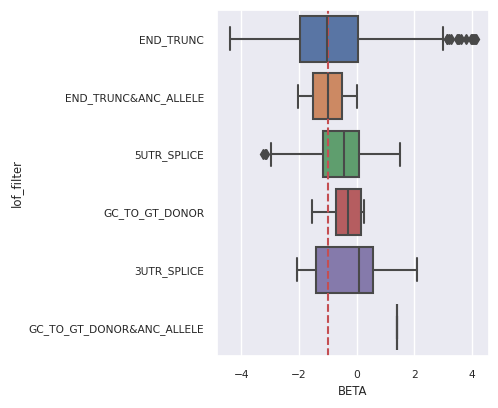

In [94]:
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(3.5,4.5))
sns.boxplot(data=loftee, y='lof_filter', x='BETA')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

In [84]:
loftee.loc[loftee['lof_filter']=='5UTR_SPLICE',:].groupby('consequence')['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
splice_acceptor_variant,66.0,-0.62433,1.100300,-3.25678,-1.020012,-0.408251,0.052038,1.497150
splice_donor_variant,15.0,-0.81744,1.198209,-3.17732,-1.727240,-0.781055,0.209108,0.678204


In [85]:
loftee.loc[loftee['lof_filter']=='3UTR_SPLICE',:].groupby('consequence')['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
splice_acceptor_variant,2.0,0.044635,1.018012,-0.675208,-0.315287,0.044635,0.404556,0.764478
splice_donor_variant,14.0,-0.286123,1.260335,-2.063410,-1.590935,0.058909,0.450405,2.092810


Text(0, 0.5, 'lof percentage')

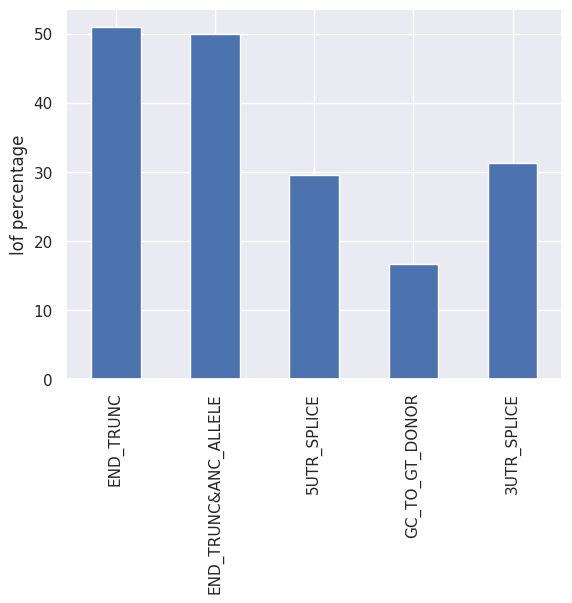

In [14]:
# plot percentage of each filter that is loss-of-function
(filter_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [65]:
loftee.groupby(['lof_filter','consequence'], observed=True).count()['ID']

lof_filter                 consequence            
END_TRUNC                  frameshift_variant         541
                           stop_gained                414
END_TRUNC&ANC_ALLELE       stop_gained                  2
5UTR_SPLICE                splice_acceptor_variant     66
                           splice_donor_variant        15
GC_TO_GT_DONOR             splice_donor_variant         6
3UTR_SPLICE                splice_acceptor_variant      2
                           splice_donor_variant        14
GC_TO_GT_DONOR&ANC_ALLELE  splice_donor_variant         1
Name: ID, dtype: int64

Text(0, 0.5, 'lof percentage')

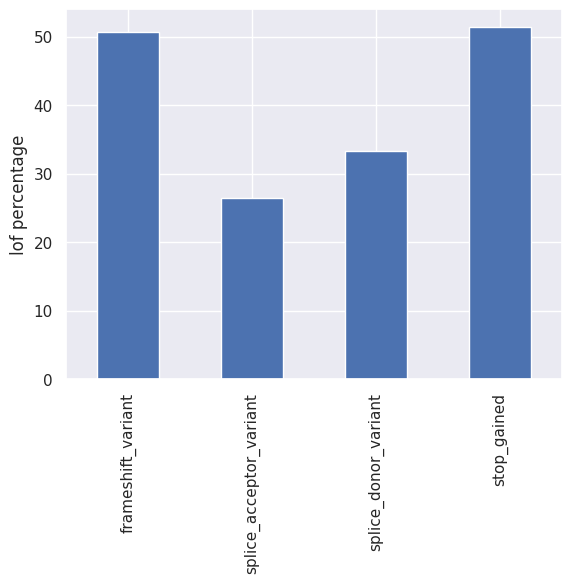

In [66]:
# plot percentage of each consequence that is loss-of-function
LCcons = LC.groupby(['consequence'], observed=True)
(LCcons['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [79]:
# Dummy variables for LOFTEE filters
filters = pd.get_dummies(loftee['filter'], drop_first=False)
filters.drop('HC', axis=1, inplace=True)

In [80]:
# logistic regression model of loss of function classification vs. LOFTEE filters
X = filters
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                           Estimate  Std_Error      z_val     p_val
intercept                  0.359708   0.016833  21.369640  0.000000
END_TRUNC&ANC_ALLELE      -0.054212   1.430843  -0.037888  0.969777
GC_TO_GT_DONOR&ANC_ALLELE -0.183095   2.007874  -0.091189  0.927343
END_TRUNC                 -0.313532   0.066888  -4.687398  0.000003
GC_TO_GT_DONOR            -0.728760   0.830607  -0.877383  0.380279
3UTR_SPLICE               -1.079554   0.533003  -2.025418  0.042824
5UTR_SPLICE               -1.164240   0.241034  -4.830186  0.000001


col_0               0      1    All
loss_of_function                   
0                  73   6459   6532
1                  30   9078   9108
All               103  15537  15640

Evaluation metrics with threshold 0.5:
Total: 15640
Correct predictions (accuracy): 9151 (58.5%)
TPR (recall/sensitivity)=TP/P: 99.7%
TNR (specificity)=TN/N: 1.1%
PPV (precision)=TP/(TP+FP): 58.4%
FDR (false discovery)=1-PPV: 41.6%
FPR (false positive rate)=FP/N=1-TNR: 98.

intercept/reference = HC  
5UTR_SPLICE, 3UTR_SPLICE and END_TRUNC are significant (p<0.05).

Area Under the ROC Curve: 0.5133042447559275


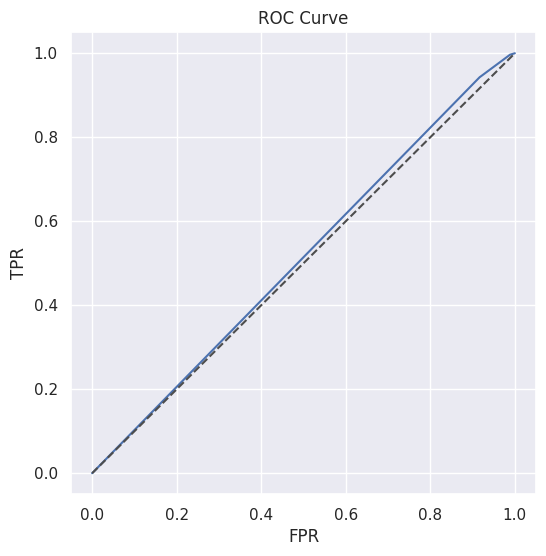

In [81]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

### END_TRUNC breakdown

In [42]:
trunc = loftee.loc[loftee['lof_filter']=='END_TRUNC',:]
trunc_cons = trunc.groupby(['consequence'], observed=True)
trunc_cons['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
frameshift_variant,541.0,-0.921052,1.425770,-4.31082,-1.999890,-1.013810,0.029691,4.14319
stop_gained,414.0,-0.875392,1.457091,-4.40800,-1.937242,-1.056005,0.032204,4.10219


Text(0.5, 1.0, 'END_TRUNC')

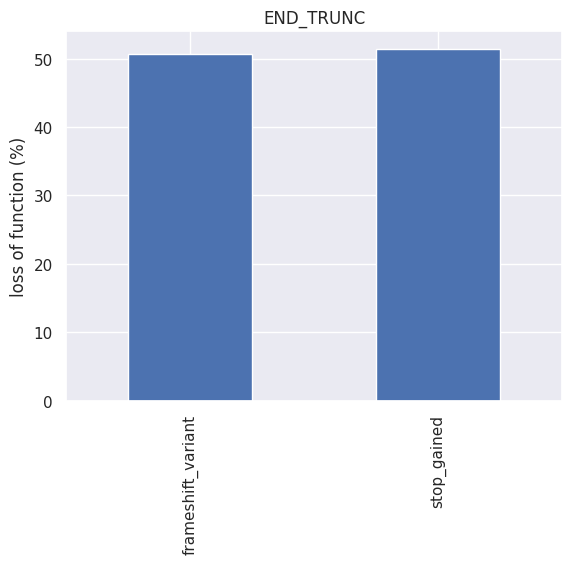

In [33]:
(trunc_cons['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("loss of function (%)") ## Set Y-axis label
plt.title('END_TRUNC')

In [30]:
print(len(trunc.loc[trunc['consequence']=='frameshift_variant',:])/len(loftee.loc[loftee['consequence']=='frameshift_variant',:])*100)
print(len(trunc.loc[trunc['consequence']=='stop_gained',:])/len(loftee.loc[loftee['consequence']=='stop_gained',:])*100)

8.248208568379326
7.672349888806523


In [17]:
trunc_grp = trunc.groupby('freq')
trunc_grp['BETA'].describe()

/var/tmp/ipykernel_7245/1507242911.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trunc_grp = trunc.groupby('freq')


,count,mean,std,min,25%,50%,75%,max
freq,,,,,,,,
singleton,562.0,-0.919252,1.503571,-4.40800,-2.028963,-1.112470,0.092871,4.102190
doubleton,144.0,-0.782073,1.571749,-3.42763,-1.989132,-0.955765,0.259461,4.143190
<0.01%,163.0,-0.960450,1.256050,-3.71977,-1.913690,-0.962973,-0.131148,3.479570
0.01-0.1%,63.0,-0.983181,1.115521,-2.58993,-1.867240,-1.200220,-0.364642,2.190120
0.1-1%,13.0,-0.588949,0.935530,-2.22767,-1.279990,-0.034641,0.076594,0.409574
1-10%,8.0,-0.407170,0.736753,-1.32997,-0.959918,-0.403317,0.004610,0.795204
>10%,2.0,-1.028153,0.114773,-1.10931,-1.068731,-1.028153,-0.987575,-0.946996


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


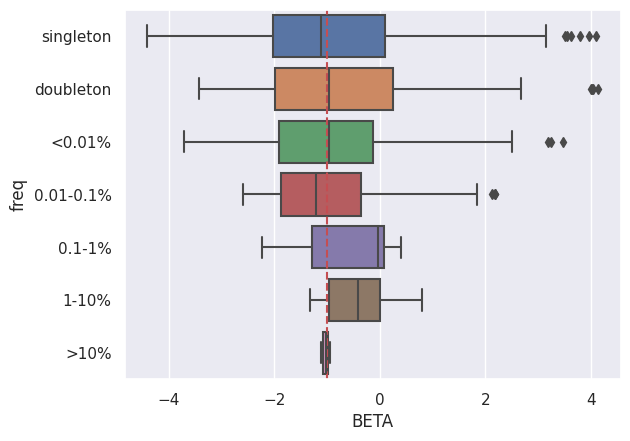

In [70]:
sns.boxplot(data=loftee.loc[loftee['lof_filter']=='END_TRUNC',:], x='BETA', y='freq')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

Text(0, 0.5, 'lof percentage')

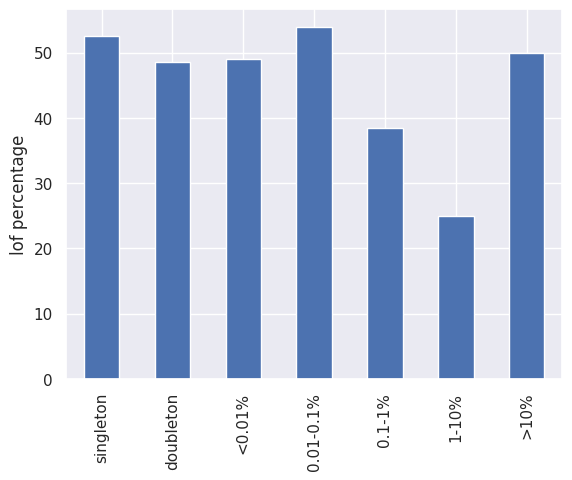

In [18]:
# plot percentage of each END_TRUNC at each allele frequency that is loss-of-function
(trunc_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

/var/tmp/ipykernel_7245/2007790252.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trunc_frame_grp = trunc_frame.groupby('freq')


Text(0, 0.5, 'lof percentage')

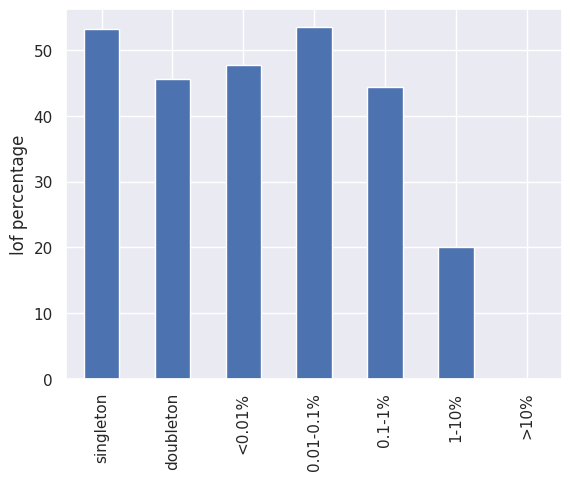

In [34]:
# plot percentage of each END_TRUNC at each allele frequency that is loss-of-function
trunc_frame = trunc.loc[trunc['consequence']=='frameshift_variant',:]
trunc_frame_grp = trunc_frame.groupby('freq')
(trunc_frame_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

/var/tmp/ipykernel_7245/3089754948.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trunc_stop_grp = trunc_stop.groupby('freq')


Text(0, 0.5, 'lof percentage')

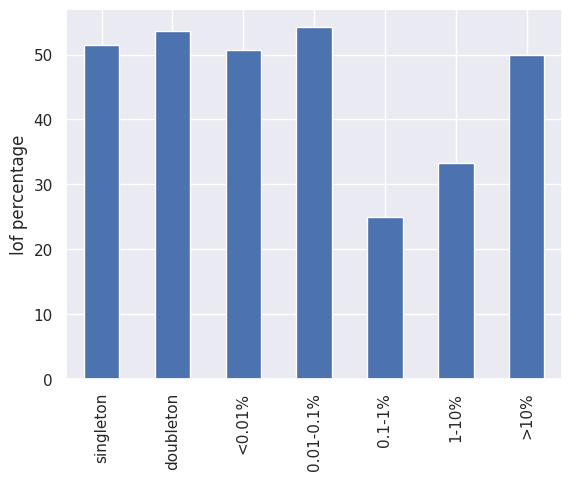

In [35]:
# plot percentage of each END_TRUNC at each allele frequency that is loss-of-function
trunc_stop = trunc.loc[trunc['consequence']=='stop_gained',:]
trunc_stop_grp = trunc_stop.groupby('freq')
(trunc_stop_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [43]:
trunc['single_ex'] = ['single' if i=='SINGLE_EXON' else 'multiple' for i in trunc['lof_flags']]

/var/tmp/ipykernel_7245/3041307108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunc['single_ex'] = ['single' if i=='SINGLE_EXON' else 'multiple' for i in trunc['lof_flags']]


In [44]:
trunc_exon = trunc.groupby('single_ex')
trunc_exon['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
single_ex,,,,,,,,
multiple,925.0,-0.877389,1.425247,-4.40800,-1.96578,-0.995980,0.038032,4.14319
single,30.0,-1.637225,1.674679,-4.31082,-2.26343,-1.896495,-1.494032,3.97575


Text(0, 0.5, 'lof percentage')

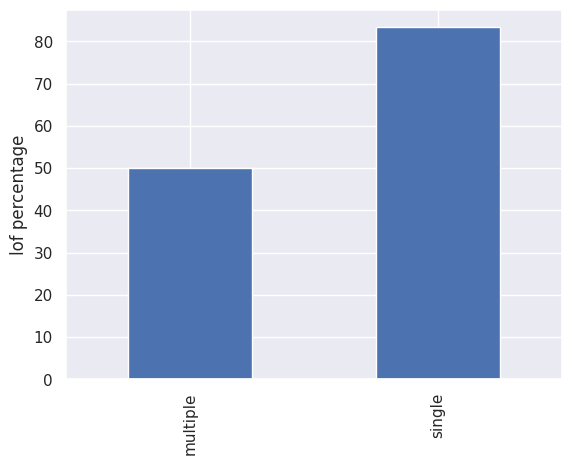

In [45]:
# plot percentage of each END_TRUNC at each allele frequency that is loss-of-function
(trunc_exon['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [53]:
x='10/11'
x.split('/')[0]

'10'

In [62]:
trunc['exon_num'] = [int(i.split('/')[0]) for i in trunc['exon']]

/var/tmp/ipykernel_7245/1139608481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunc['exon_num'] = [int(i.split('/')[0]) for i in trunc['exon']]


In [76]:
trunc['exon_num2'] = ['>15' if i>15 else i for i in trunc['exon_num']]

/var/tmp/ipykernel_7245/737256102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trunc['exon_num2'] = ['>15' if i>15 else i for i in trunc['exon_num']]


In [77]:
exon_grp = trunc.groupby('exon_num2')
exon_grp['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
exon_num2,,,,,,,,
1,45.0,-1.609694,1.589032,-4.31082,-2.263430,-1.889020,-1.257180,3.975750
2,114.0,-1.536535,1.121988,-3.44465,-2.363640,-1.745445,-0.744475,2.124050
3,84.0,-1.030572,1.231751,-3.26235,-1.900730,-1.032395,-0.289663,2.977040
4,71.0,-0.505272,1.968210,-3.71977,-2.204245,-0.498443,0.905492,4.143190
5,112.0,-1.040429,1.403815,-4.40800,-1.932285,-1.210625,-0.094380,3.506870
6,76.0,-1.155900,1.218866,-3.20435,-2.127570,-1.411790,-0.434410,2.404210
7,94.0,-1.014453,1.502005,-3.55129,-2.222047,-1.056920,0.062927,3.998340
8,73.0,-0.718930,1.275246,-2.57691,-1.811040,-0.595538,0.211534,4.102190
9,43.0,-0.719925,1.656666,-3.28137,-1.978720,-0.895763,0.179242,3.624130


Text(0.5, 1.0, 'END_TRUNC')

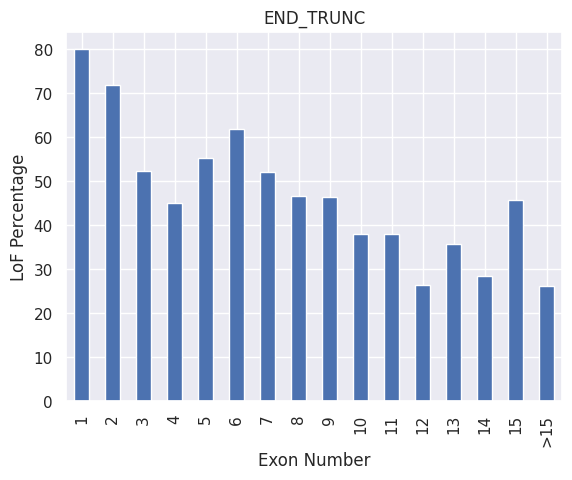

In [86]:
# plot percentage of each END_TRUNC at each allele frequency that is loss-of-function
(exon_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("Exon Number") ## Set X-axis label
plt.gca().set_ylabel("LoF Percentage") ## Set Y-axis label
plt.title("END_TRUNC")

## LOFTEE Flags

LOFTEE implements a series of flags in addition to the above filters. Flagged variants should be treated with caution, particularly when doing genome-wide scans of LoF variation. However, they largely relate to the properties of individual transcripts or exons, so domain knowledge of a given gene will typically outperform these flags.

For stop-gained and frameshift variants, LOFTEE flags:

Variants in genes with only a single exon  
Variants in exons that do not have the evolutionary signature of a protein-coding gene based on PhyloCSF  
Variants where no exon number is indicated (apparently because the variant overlaps an intron)  

For splice-site variants, LOFTEE flags:

Variants in NAGNAG sites (acceptor sites rescued by in-frame acceptor site)  
Variants that fall in an intron with a non-canonical splice site (i.e. intron does not start with GT and end with AG).  

Possible values for the Lof_flags field are:

SINGLE_EXON The LoF falls in a single exon transcript.

NAGNAG_SITE The LoF is a splice variant that falls into a NAGNAG sequence, which may indicate a frame-restoring splice site.

PHYLOCSF_WEAK The LoF falls in an exon that does not exhibit a pattern of conservation typical of a protein-coding exon.

PHYLOCSF_UNLIKELY_ORF The LoF falls in an exon that exhibits a pattern of conservation typical of a protein-coding exon, but the reading frame is likely offset.

NON_CAN_SPLICE The LoF is a splice variant that falls in a non-canonical splice site (not GT..AG).

In [171]:
loftee['flags'] = loftee['lof_flags'].fillna('unflagged')

/var/tmp/ipykernel_7245/1759215121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['flags'] = loftee['lof_flags'].fillna('unflagged')


In [172]:
flag_grp = loftee.groupby('lof_flags', sort=False)
sorted_flags = flag_grp['BETA'].median().sort_values()
custom_order = sorted_flags.index.tolist()
loftee['lof_flags'] = pd.Categorical(loftee['lof_flags'], categories=custom_order, ordered=True)
flag_grp = loftee.groupby('lof_flags', observed=True)
flag_grp['BETA'].describe()

/var/tmp/ipykernel_7245/1229060661.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['lof_flags'] = pd.Categorical(loftee['lof_flags'], categories=custom_order, ordered=True)


,count,mean,std,min,25%,50%,75%,max
lof_flags,,,,,,,,
SINGLE_EXON,47.0,-1.576181,1.714835,-4.31082,-2.349380,-1.902650,-1.366650,3.97575
PHYLOCSF_WEAK,2719.0,-1.081509,1.321936,-4.40800,-2.055415,-1.106790,-0.183886,4.44317
NAGNAG_SITE,94.0,-0.693876,1.415594,-3.51375,-1.607433,-0.774182,0.053910,3.93927
NON_CAN_SPLICE,32.0,-0.776914,1.484827,-3.27475,-2.172425,-0.665366,0.271162,3.44451
PHYLOCSF_UNLIKELY_ORF,9.0,-0.446735,0.862134,-1.52455,-0.983054,-0.571650,-0.071164,1.29693


In [175]:
flag_grp2 = loftee.groupby('flags', sort=False)
sorted_flags = flag_grp2['BETA'].median().sort_values()
custom_order = sorted_flags.index.tolist()
loftee['flags'] = pd.Categorical(loftee['flags'], categories=custom_order, ordered=True)
flag_grp2 = loftee.groupby('flags', observed=True)
flag_grp2['BETA'].describe()

/var/tmp/ipykernel_7245/1845077681.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  flag_grp2 = loftee.groupby('flags', sort=False)
/var/tmp/ipykernel_7245/1845077681.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['flags'] = pd.Categorical(loftee['flags'], categories=custom_order, ordered=True)


,count,mean,std,min,25%,50%,75%,max
flags,,,,,,,,
SINGLE_EXON,47.0,-1.576181,1.714835,-4.31082,-2.349380,-1.902650,-1.366650,3.97575
unflagged,12739.0,-1.266329,1.315410,-4.48307,-2.239315,-1.346910,-0.394482,4.65809
PHYLOCSF_WEAK,2719.0,-1.081509,1.321936,-4.40800,-2.055415,-1.106790,-0.183886,4.44317
NAGNAG_SITE,94.0,-0.693876,1.415594,-3.51375,-1.607433,-0.774182,0.053910,3.93927
NON_CAN_SPLICE,32.0,-0.776914,1.484827,-3.27475,-2.172425,-0.665366,0.271162,3.44451
PHYLOCSF_UNLIKELY_ORF,9.0,-0.446735,0.862134,-1.52455,-0.983054,-0.571650,-0.071164,1.29693


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


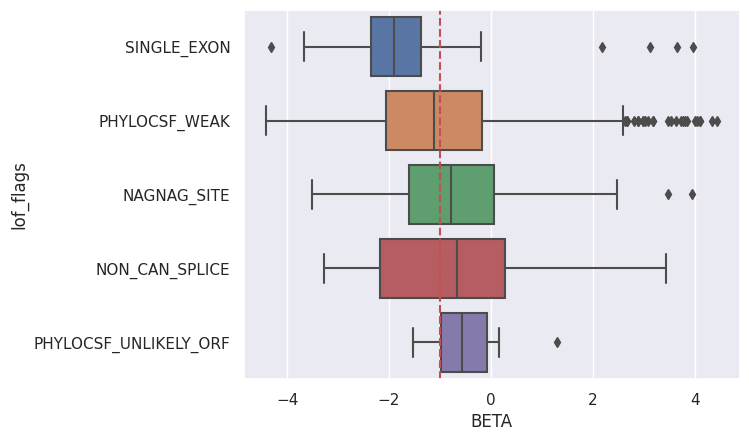

In [72]:
sns.boxplot(data=loftee, y='lof_flags', x='BETA')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


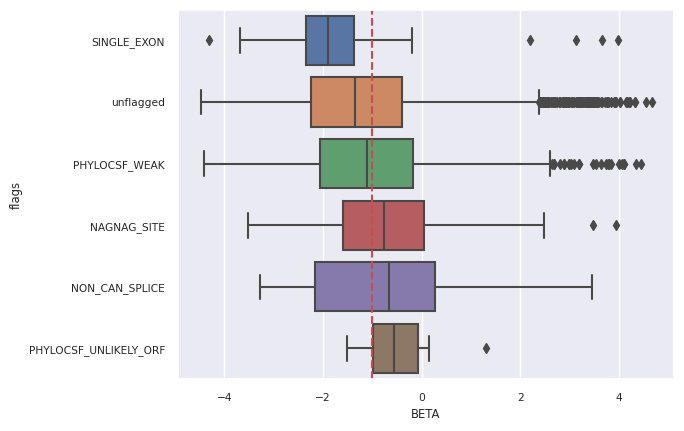

In [176]:
sns.boxplot(data=loftee, y='flags', x='BETA')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

Text(0, 0.5, 'lof percentage')

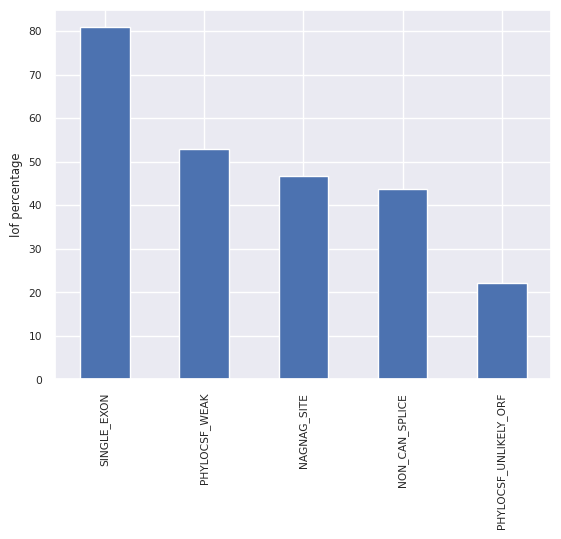

In [99]:
# plot percentage of each flag that is loss-of-function
(flag_grp['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

Text(0, 0.5, 'lof percentage')

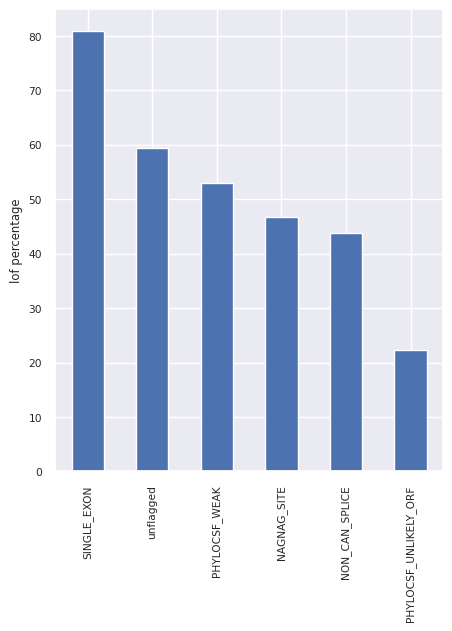

In [298]:
# plot percentage of each flag that is loss-of-function
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(5,6))
(flag_grp2['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [178]:
(flag_grp2['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])

flags
SINGLE_EXON              80.851064
unflagged                59.423817
PHYLOCSF_WEAK            52.960647
NAGNAG_SITE              46.808511
NON_CAN_SPLICE           43.750000
PHYLOCSF_UNLIKELY_ORF    22.222222
Name: proportion, dtype: float64

In [201]:
loftee.groupby(['lof','flags'])['BETA'].describe()

/var/tmp/ipykernel_7245/2619362062.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loftee.groupby(['lof','flags'])['BETA'].describe()


count      mean       std       min       25%  \
lof flags                                                                    
HC  SINGLE_EXON               17.0 -1.468455  1.830800 -3.337540 -2.590020   
    unflagged              12134.0 -1.284050  1.308635 -4.483070 -2.252887   
    PHYLOCSF_WEAK           2308.0 -1.135278  1.298609 -4.404980 -2.112650   
    NAGNAG_SITE               89.0 -0.737849  1.438338 -3.513750 -1.651340   
    NON_CAN_SPLICE            23.0 -1.049638  1.606826 -3.274750 -2.317055   
    PHYLOCSF_UNLIKELY_ORF      8.0 -0.461649  0.920418 -1.524550 -1.086983   
LC  SINGLE_EXON               30.0 -1.637225  1.674679 -4.310820 -2.263430   
    unflagged                605.0 -0.910914  1.399081 -4.046600 -1.999460   
    PHYLOCSF_WEAK            411.0 -0.779566  1.409996 -4.408000 -1.806470   
    NAGNAG_SITE                5.0  0.088830  0.517775 -0.656695 -0.031779   
    NON_CAN_SPLICE             9.0 -0.079954  0.826288 -1.567220 -0.445428   
    PHYLOCSF_UNLIKELY_ORF      1.0 -0.327423       NaN -0.327423 -0.327423   

                                50%       75%       max  
lof flags                                                
HC  SINGLE_EXON           -1.988270 -1.267400  3.657500  
    unflagged             -1.363585 -0.418442  4.658090  
    PHYLOCSF_WEAK         -1.156985 -0.218186  4.443170  
    NAGNAG_SITE           -0.870381  0.032603  3.939270  
    NON_CAN_SPLICE        -1.264080  0.045147  3.444510  
    PHYLOCSF_UNLIKELY_ORF -0.582086 -0.015476  1.296930  
LC  SINGLE_EXON           -1.896495 -1.494032  3.975750  
    unflagged             -1.001750  0.048740  4.143190  
    PHYLOCSF_WEAK         -0.875584  0.085019  4.102190  
    NAGNAG_SITE            0.052545  0.323810  0.756270  
    NON_CAN_SPLICE         0.018483  0.261939  1.382760  
    PHYLOCSF_UNLIKELY_ORF -0.327423 -0.327423 -0.327423

In [216]:
HC_flag = loftee.loc[loftee['lof']=='HC',:].groupby('flags')
x = (HC_flag['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x

/var/tmp/ipykernel_7245/3398377141.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  HC_flag = loftee.loc[loftee['lof']=='HC',:].groupby('flags')


flags
SINGLE_EXON              76.470588
unflagged                59.881325
PHYLOCSF_WEAK            54.246101
NAGNAG_SITE              49.438202
NON_CAN_SPLICE           56.521739
PHYLOCSF_UNLIKELY_ORF    25.000000
Name: proportion, dtype: float64

Text(0.5, 1.0, 'HC variants')

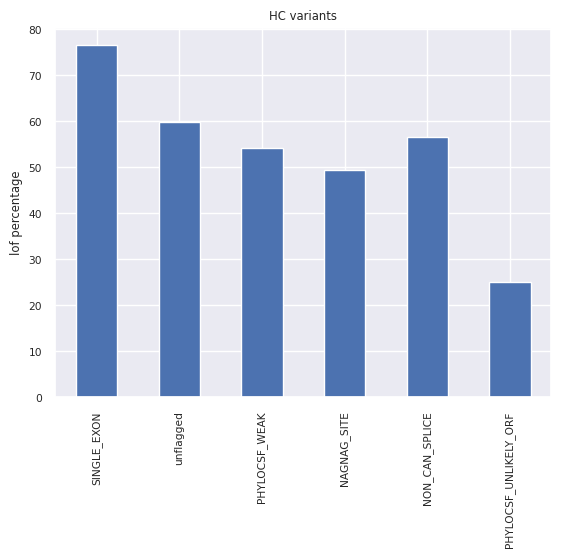

In [200]:
# plot percentage of each flag that is loss-of-function
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label
plt.title('HC variants')

In [217]:
LC_flag = loftee.loc[loftee['lof']=='LC',:].groupby('flags')
x2 = (LC_flag['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x2

/var/tmp/ipykernel_7245/3933749828.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LC_flag = loftee.loc[loftee['lof']=='LC',:].groupby('flags')


flags
SINGLE_EXON              83.333333
unflagged                50.247934
PHYLOCSF_WEAK            45.742092
NAGNAG_SITE               0.000000
NON_CAN_SPLICE           11.111111
PHYLOCSF_UNLIKELY_ORF     0.000000
Name: proportion, dtype: float64

Text(0.5, 1.0, 'LC variants')

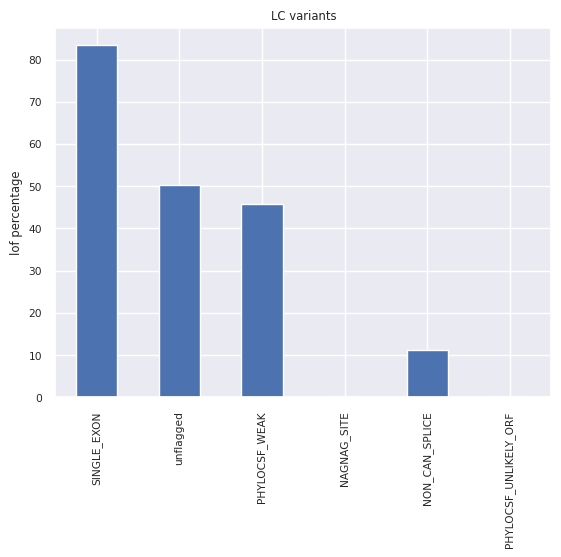

In [218]:
# plot percentage of each flag that is loss-of-function
x2.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label
plt.title('LC variants')

In [287]:
x3 = pd.concat([x,x2], axis=0)
y = loftee.groupby(['lof','flags'])['BETA'].count()
y2 = y.to_frame()
y2['LoF_Percentage'] = x3.tolist()
y2.columns = ['count', 'LoF_Percentage']
y2

/var/tmp/ipykernel_7245/311697501.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  y = loftee.groupby(['lof','flags'])['BETA'].count()


count  LoF_Percentage
lof flags                                       
HC  SINGLE_EXON               17       76.470588
    unflagged              12134       59.881325
    PHYLOCSF_WEAK           2308       54.246101
    NAGNAG_SITE               89       49.438202
    NON_CAN_SPLICE            23       56.521739
    PHYLOCSF_UNLIKELY_ORF      8       25.000000
LC  SINGLE_EXON               30       83.333333
    unflagged                605       50.247934
    PHYLOCSF_WEAK            411       45.742092
    NAGNAG_SITE                5        0.000000
    NON_CAN_SPLICE             9       11.111111
    PHYLOCSF_UNLIKELY_ORF      1        0.000000

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='LoF_Percentage', ylabel='flags'>

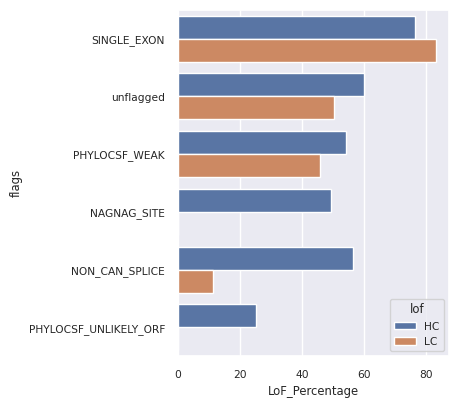

In [290]:
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(3.5,4.5))
y3 = y2.reset_index()
sns.barplot(data=y3, y='flags', x='LoF_Percentage', hue='lof')

### SINGLE_EXON analysis

In [109]:
sing_ex = loftee.loc[loftee['lof_flags']=='SINGLE_EXON',:]
ex_cons = sing_ex.groupby('consequence')
ex_cons['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
frameshift_variant,28.0,-1.884496,1.434591,-4.31082,-2.427300,-1.92481,-1.510155,3.97575
stop_gained,19.0,-1.121822,2.015481,-3.33754,-2.208775,-1.82960,-0.811816,3.65750


In [135]:
(ex_cons['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])

consequence
frameshift_variant    89.285714
stop_gained           68.421053
Name: proportion, dtype: float64

Text(0.5, 1.0, 'SINGLE_EXON')

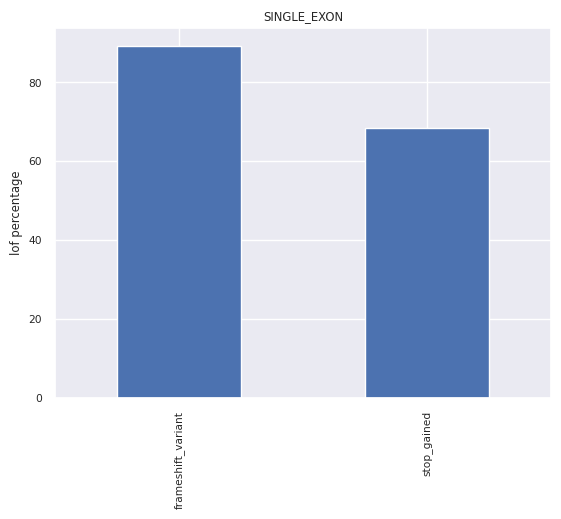

In [111]:
# plot percentage of each flag that is loss-of-function
(ex_cons['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label
plt.title('SINGLE_EXON')

In [115]:
ex_freq = sing_ex.groupby('freq')
ex_freq['BETA'].describe()

/var/tmp/ipykernel_7245/2171466819.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ex_freq = sing_ex.groupby('freq')


,count,mean,std,min,25%,50%,75%,max
freq,,,,,,,,
singleton,32.0,-1.407330,2.010837,-4.31082,-2.455608,-1.904690,-1.047295,3.97575
doubleton,8.0,-2.037055,0.944646,-3.33754,-2.653710,-1.938645,-1.730822,-0.19974
<0.01%,7.0,-1.821354,0.327647,-2.37306,-1.993770,-1.829600,-1.546690,-1.46590
0.01-0.1%,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.1-1%,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-10%,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
>10%,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
# plot percentage of each flag that is loss-of-function
x = (ex_freq['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x

freq
singleton     75.0
doubleton     87.5
<0.01%       100.0
0.01-0.1%      0.0
0.1-1%         0.0
1-10%          0.0
>10%           0.0
Name: proportion, dtype: float64

In [156]:
y = ex_freq['BETA'].count().astype('int')
z = pd.DataFrame([y, x])
z.index = ['count', 'LoF Percentage']
print('SINGLE_EXON')
print(z)

SINGLE_EXON
freq            singleton  doubleton  <0.01%  0.01-0.1%  0.1-1%  1-10%  >10%
count                32.0        8.0     7.0        0.0     0.0    0.0   0.0
LoF Percentage       75.0       87.5   100.0        0.0     0.0    0.0   0.0


Text(0.5, 1.0, 'SINGLE_EXON')

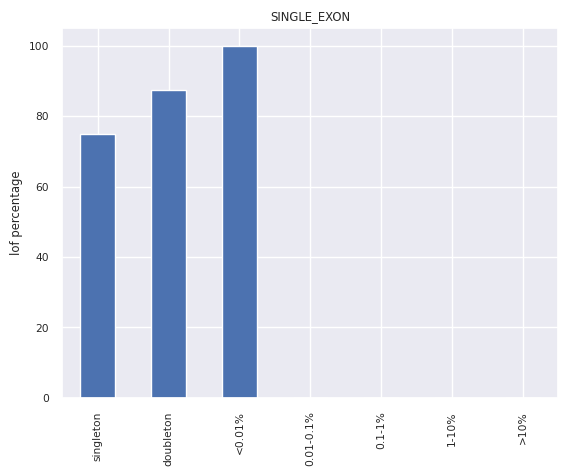

In [134]:
# plot percentage of each flag that is loss-of-function
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label
plt.title('SINGLE_EXON')
#y = ex_freq['BETA'].count()
#for i in range(len(x)):
#        plt.text(i,x[i],y[i],ha = 'center')

In [138]:
ex_cons_freq = sing_ex.groupby(['consequence','freq'])
ex_cons_freq['BETA'].describe()

/var/tmp/ipykernel_7245/2394487152.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ex_cons_freq = sing_ex.groupby(['consequence','freq'])


count      mean       std      min       25%  \
consequence        freq                                                      
frameshift_variant singleton   19.0 -1.890482  1.737843 -4.31082 -2.892150   
                   doubleton    5.0 -1.982876  0.357911 -2.59002 -1.988270   
                   <0.01%       4.0 -1.733085  0.429130 -2.37306 -1.777087   
stop_gained        singleton   13.0 -0.701186  2.237335 -3.14587 -2.188130   
                   doubleton    3.0 -2.127353  1.687446 -3.33754 -3.091160   
                   <0.01%       3.0 -1.939047  0.097306 -2.01578 -1.993770   

                                  50%       75%      max  
consequence        freq                                   
frameshift_variant singleton -2.01038 -1.495180  3.97575  
                   doubleton -1.88902 -1.738110 -1.70896  
                   <0.01%    -1.54669 -1.502687 -1.46590  
stop_gained        singleton -1.26740 -0.650934  3.65750  
                   doubleton -2.84478 -1.522260 -0.19974  
                   <0.01%    -1.97176 -1.900680 -1.82960

In [144]:
ex_frame_freq = sing_ex.loc[sing_ex['consequence']=='frameshift_variant',:].groupby('freq')
x = (ex_frame_freq['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
y = ex_frame_freq['BETA'].describe()
z = pd.DataFrame([y.iloc[:,0], x])
z.index = ['count', 'LoF Percentage']
z

/var/tmp/ipykernel_7245/3356365139.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ex_frame_freq = sing_ex.loc[sing_ex['consequence']=='frameshift_variant',:].groupby('freq')


freq,singleton,doubleton,<0.01%,0.01-0.1%,0.1-1%,1-10%,>10%
count,19.000000,5.0,4.0,0.0,0.0,0.0,0.0
LoF Percentage,84.210526,100.0,100.0,0.0,0.0,0.0,0.0


In [146]:
ex_stop_freq = sing_ex.loc[sing_ex['consequence']=='stop_gained',:].groupby('freq')
x = (ex_stop_freq['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
y = ex_stop_freq['BETA'].describe()
z = pd.DataFrame([y.iloc[:,0], x])
z.index = ['count', 'LoF Percentage']
z

/var/tmp/ipykernel_7245/3525115188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ex_stop_freq = sing_ex.loc[sing_ex['consequence']=='stop_gained',:].groupby('freq')


freq,singleton,doubleton,<0.01%,0.01-0.1%,0.1-1%,1-10%,>10%
count,13.000000,3.000000,3.0,0.0,0.0,0.0,0.0
LoF Percentage,61.538462,66.666667,100.0,0.0,0.0,0.0,0.0


In [73]:
loftee.groupby(['lof_flags', 'lof'], observed=True).count()['ID']

lof_flags              lof
SINGLE_EXON            HC       17
                       LC       30
PHYLOCSF_WEAK          HC     2308
                       LC      411
NAGNAG_SITE            HC       89
                       LC        5
NON_CAN_SPLICE         HC       23
                       LC        9
PHYLOCSF_UNLIKELY_ORF  HC        8
                       LC        1
Name: ID, dtype: int64

In [74]:
# Performing two-way ANOVA to assess interaction term between LOFTEE confidence and LOFTEE flag
model = ols('BETA ~ C(lof) + C(lof_flags) + C(lof):C(lof_flags)', 
            data=loftee).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result) 

                         df       sum_sq    mean_sq          F    PR(>F)
C(lof)                  1.0    36.564680  36.564680  20.760175  0.000005
C(lof_flags)            4.0    42.642344  10.660586   6.052716  0.000076
C(lof):C(lof_flags)     4.0     6.516787   1.629197   0.925002  0.448283
Residual             2891.0  5091.888241   1.761290        NaN       NaN


There is a significant interaction effect between LOFTEE confidence and flag annotations on betas.  
LOFTEE flag effect shouldn't be assessed independently. It is dependent on confidence annotation.

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


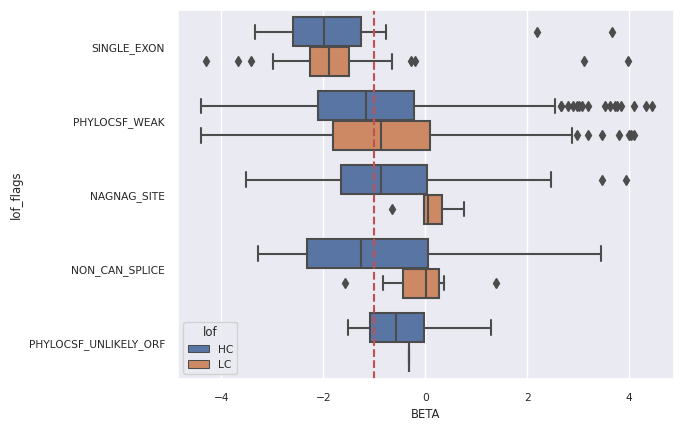

In [157]:
sns.boxplot(data=loftee, y='lof_flags', x='BETA', hue='lof')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


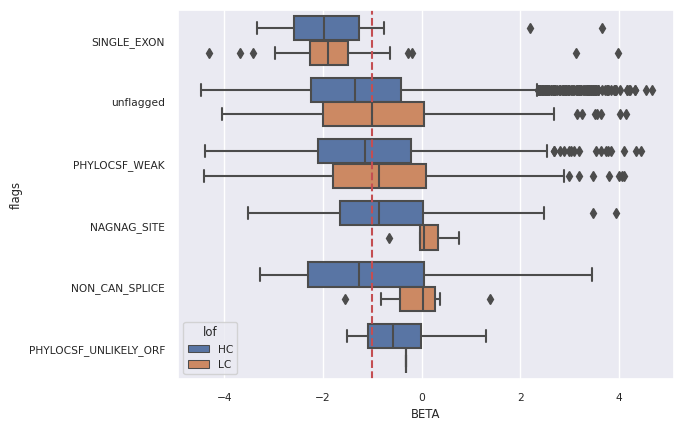

In [179]:
sns.boxplot(data=loftee, y='flags', x='BETA', hue='lof')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

In [76]:
# Dummy variables for LOFTEE flags
flags = pd.get_dummies(loftee['lof_flags'], dummy_na=True)
flags.drop(np.nan, axis=1, inplace=True)

In [107]:
# logistic regression model of loss of function classification vs. LOFTEE flags
X = flags
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                       Estimate  Std_Error      z_val         p_val
SINGLE_EXON            1.035229   0.368337   2.810546  4.945759e-03
intercept              0.380259   0.018041  21.077292  0.000000e+00
PHYLOCSF_WEAK         -0.261222   0.042448  -6.153933  7.558447e-10
NAGNAG_SITE           -0.464367   0.207253  -2.240575  2.505361e-02
NON_CAN_SPLICE        -0.611668   0.356380  -1.716337  8.610033e-02
PHYLOCSF_UNLIKELY_ORF -0.658066   0.673350  -0.977301  3.284202e-01


col_0               0      1    All
loss_of_function                   
0                  75   6457   6532
1                  60   9048   9108
All               135  15505  15640

Evaluation metrics with threshold 0.5:
Total: 15640
Correct predictions (accuracy): 9123 (58.3%)
TPR (recall/sensitivity)=TP/P: 99.3%
TNR (specificity)=TN/N: 1.1%
PPV (precision)=TP/(TP+FP): 58.4%
FDR (false discovery)=1-PPV: 41.6%
FPR (false positive rate)=FP/N=1-TNR: 98.9%
F1 score: 73.5%
OR (odds ratio)=(TP/FP)/(FN/TN): 1.75
Fisher exac

intercept/reference = all unflagged variants (regardless of LOFTEE confidence)  
'SINGLE_EXON' are significantly more likely to be LoF than unflagged (p<0.05)   
'PHYLOCSF_WEAK' and 'NAGNAG_SITE' are less likely to be LoF than unflagged variants (p<0.05)

Area Under the ROC Curve: 0.5226423726333868


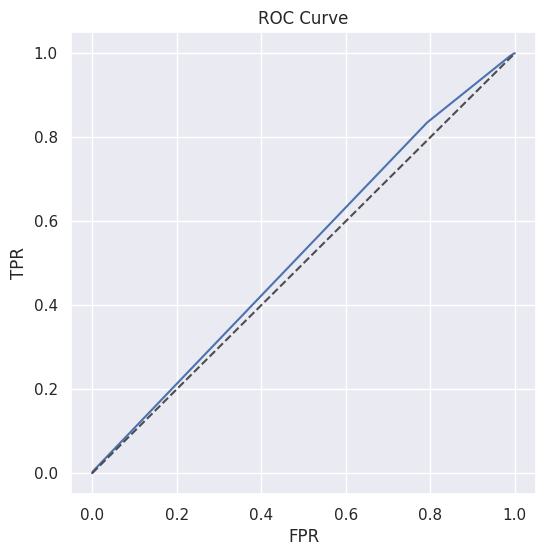

In [108]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [159]:
# combine LOFTEE confidence and flag annotations
loftee['conf_flag'] = loftee['lof'].astype(str) + "," + loftee['lof_flags'].astype(str)

/var/tmp/ipykernel_7245/4207843873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loftee['conf_flag'] = loftee['lof'].astype(str) + "," + loftee['lof_flags'].astype(str)


In [79]:
# Dummy variables for combined LOFTEE confidence/flags
flags2 = pd.get_dummies(loftee['conf_flag'])
# Drop HC + no flag group - this will be the reference for the LR model
flags2.drop("HC,nan", axis=1, inplace=True)

In [104]:
# logistic regression model of loss of function classification vs. LOFTEE flags
X = flags2
y = loftee['loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                          Estimate  Std_Error      z_val         p_val
LC,SINGLE_EXON            0.968151   0.454208   2.131513  3.304689e-02
HC,SINGLE_EXON            0.648862   0.553491   1.172309  2.410732e-01
intercept                 0.398967   0.018519  21.543906  0.000000e+00
HC,NON_CAN_SPLICE        -0.103903   0.421982  -0.246226  8.055072e-01
HC,PHYLOCSF_WEAK         -0.227581   0.045703  -4.979507  6.374636e-07
LC,PHYLOCSF_UNLIKELY_ORF -0.316470   2.001787  -0.158094  8.743828e-01
LC,nan                   -0.384309   0.083396  -4.608254  4.060636e-06
HC,NAGNAG_SITE           -0.400099   0.212807  -1.880102  6.009416e-02
LC,PHYLOCSF_WEAK         -0.567468   0.100720  -5.634104  1.759710e-08
HC,PHYLOCSF_UNLIKELY_ORF -0.987653   0.738192  -1.337935  1.809176e-01
LC,NAGNAG_SITE           -1.265031   0.979781  -1.291137  1.966563e-01
LC,NON_CAN_SPLICE        -1.483231   0.767282  -1.933097  5.322431e-02


col_0               0      1    All
loss_of_function                   
0  

intercept/reference = HC, unflagged ptvs  
unflagged LC, 'HC,PHYLOCSF_WEAK', and 'LC,PHYLOCSF_WEAK' are significantly less likely to be LoF (p<0.05)   
'LC,SINGLE_EXON' is actually *more* likely to be LoF than unflagged HC variants

Area Under the ROC Curve: 0.5302747666903062


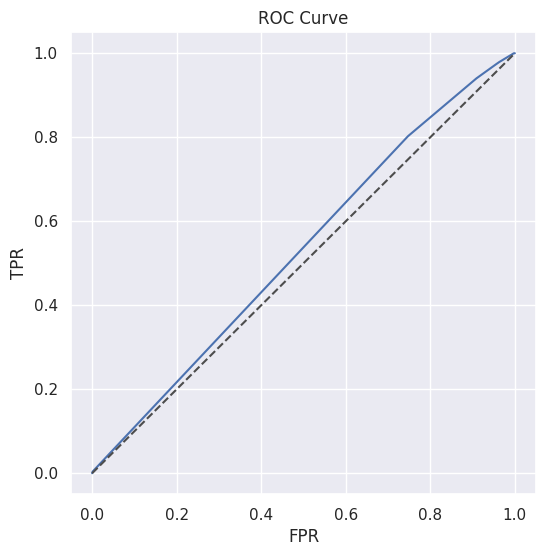

In [105]:
# ROC Curve 
y_scores = model.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_scores)

f, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr)
ax.plot((0,1), (0,1), ls="--", c=".3")
ax.set_title("ROC Curve")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

print('Area Under the ROC Curve:', roc_auc_score(y, y_scores))

In [163]:
# Dummy variables for combined LOFTEE confidence/flags
flags3 = pd.get_dummies(loftee.loc[loftee['lof']=='HC','conf_flag'])
# Drop HC + no flag group - this will be the reference for the LR model
X = flags3.drop("HC,nan", axis=1)

In [164]:
# logistic regression model of loss of function classification vs. LOFTEE flags
y = loftee.loc[loftee['lof']=='HC','loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                          Estimate  Std_Error      z_val         p_val
HC,SINGLE_EXON            0.657698   0.554871   1.185318  2.358918e-01
intercept                 0.400461   0.018522  21.621407  0.000000e+00
HC,NON_CAN_SPLICE        -0.137465   0.421047  -0.326483  7.440592e-01
HC,PHYLOCSF_WEAK         -0.229565   0.045704  -5.022890  5.089969e-07
HC,NAGNAG_SITE           -0.402878   0.212807  -1.893159  5.833679e-02
HC,PHYLOCSF_UNLIKELY_ORF -0.868380   0.726784  -1.194825  2.321553e-01


col_0              0      1    All
loss_of_function                  
0                 51   5938   5989
1                 46   8544   8590
All               97  14482  14579

Evaluation metrics with threshold 0.5:
Total: 14579
Correct predictions (accuracy): 8595 (59.0%)
TPR (recall/sensitivity)=TP/P: 99.5%
TNR (specificity)=TN/N: 0.9%
PPV (precision)=TP/(TP+FP): 59.0%
FDR (false discovery)=1-PPV: 41.0%
FPR (false positive rate)=FP/N=1-TNR: 99.1%
F1 score: 74.1%
OR (odds ratio)=(TP/FP)/(FN/TN): 

In [162]:
# Dummy variables for combined LOFTEE confidence/flags
flags4 = pd.get_dummies(loftee.loc[loftee['lof']=='LC','conf_flag'])
# Drop HC + no flag group - this will be the reference for the LR model
X = flags4.drop("LC,nan", axis=1)

In [161]:
# logistic regression model of loss of function classification vs. LOFTEE flags
y = loftee.loc[loftee['lof']=='LC','loss_of_function']
model = LogisticRegression()
model.fit(X,y)

# coef significance
pvals=logit_pvalue(model, X)
df = pd.DataFrame(data=pvals, index=['intercept']+X.columns.tolist())
print(df.sort_values('Estimate', ascending=False))
print("\n")

# confusion matrix / contingency table
pred = model.predict(X)
print(pd.crosstab(y, pred, margins=True))

# Evaluation metrics for default threshold 
print("\nEvaluation metrics with threshold 0.5:") 
assess_pred(y, pred)

                          Estimate  Std_Error     z_val     p_val
LC,SINGLE_EXON            1.304884   0.452982  2.880654  0.003969
intercept                -0.000303   0.081312 -0.003725  0.997028
LC,PHYLOCSF_WEAK         -0.168978   0.128116 -1.318941  0.187189
LC,PHYLOCSF_UNLIKELY_ORF -0.355424   2.033345 -0.174797  0.861239
LC,NON_CAN_SPLICE        -1.152374   0.784712 -1.468532  0.141960
LC,NAGNAG_SITE           -1.169809   1.055059 -1.108762  0.267533


col_0                0   1   All
loss_of_function                
0                  538   5   543
1                  493  25   518
All               1031  30  1061

Evaluation metrics with threshold 0.5:
Total: 1061
Correct predictions (accuracy): 563 (53.1%)
TPR (recall/sensitivity)=TP/P: 4.8%
TNR (specificity)=TN/N: 99.1%
PPV (precision)=TP/(TP+FP): 83.3%
FDR (false discovery)=1-PPV: 16.7%
FPR (false positive rate)=FP/N=1-TNR: 0.9%
F1 score: 9.1%
OR (odds ratio)=(TP/FP)/(FN/TN): 5.46
Fisher exact test p-value: 8.141035029983811

### PHYLOCSF_WEAK Breakdown

In [100]:
phylo = loftee.loc[loftee['lof_flags']=='PHYLOCSF_WEAK',:]
phylo_cons = phylo.groupby(['consequence'], observed=True)
phylo_cons['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
consequence,,,,,,,,
frameshift_variant,1540.0,-1.051339,1.320049,-4.40498,-2.074725,-0.990011,-0.132084,4.44317
stop_gained,1179.0,-1.120916,1.323922,-4.40800,-2.052000,-1.232180,-0.285515,4.33595


Text(0, 0.5, 'lof percentage')

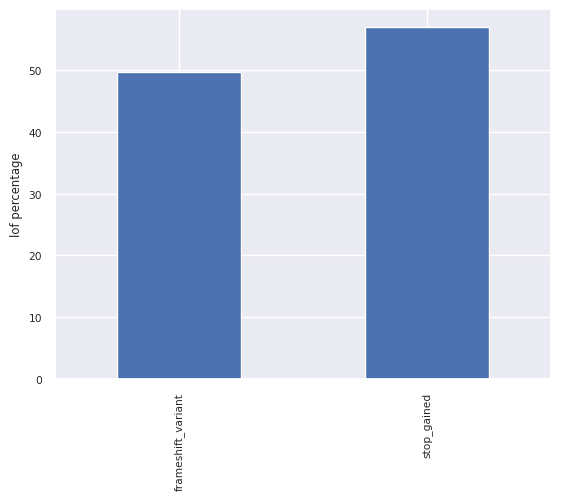

In [101]:
# plot percentage of each variant type with PHYLOCSF_WEAK flag that is loss-of-function
(phylo_cons['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [102]:
phylo_conf = phylo.groupby(['lof'], observed=True)
phylo_conf['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
lof,,,,,,,,
HC,2308.0,-1.135278,1.298609,-4.40498,-2.11265,-1.156985,-0.218186,4.44317
LC,411.0,-0.779566,1.409996,-4.40800,-1.80647,-0.875584,0.085019,4.10219


Text(0, 0.5, 'lof percentage')

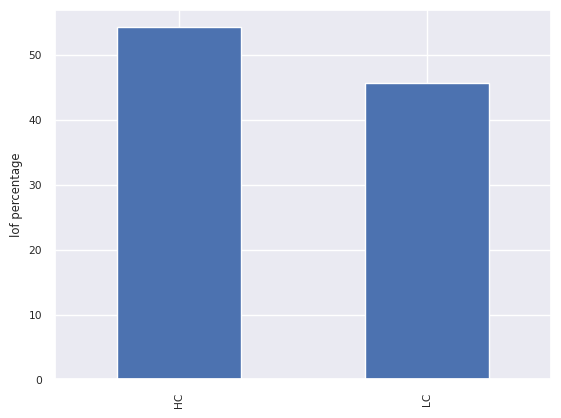

In [103]:
# plot percentage for each confidence group with PHYLOCSF_WEAK flag that is loss-of-function
(phylo_conf['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

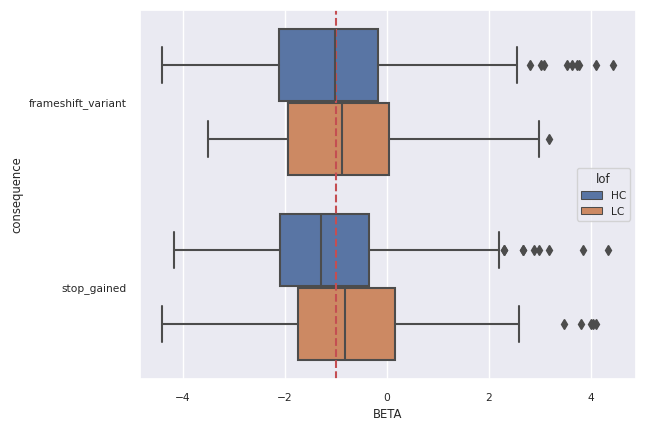

In [108]:
sns.boxplot(data=phylo, y='consequence', x='BETA', hue='lof')
plt.axvline(x = -1, color = 'r', linestyle = 'dashed')

In [104]:
phylo_freq = phylo.groupby(['freq'], observed=True)
phylo_freq['BETA'].describe()

,count,mean,std,min,25%,50%,75%,max
freq,,,,,,,,
singleton,1511.0,-1.138354,1.408854,-4.40800,-2.177180,-1.182010,-0.201514,4.443170
doubleton,435.0,-1.080452,1.265351,-3.91960,-2.030570,-1.020640,-0.256893,4.048640
<0.01%,498.0,-0.976999,1.211108,-3.46977,-1.932840,-0.942213,-0.175401,3.765180
0.01-0.1%,210.0,-1.007812,1.113157,-2.95759,-1.888667,-1.120955,-0.174752,3.084320
0.1-1%,45.0,-0.876328,0.990540,-2.47754,-1.654860,-0.949653,-0.012582,1.791470
1-10%,15.0,-0.541511,0.759365,-1.62126,-1.003416,-0.875584,-0.001309,0.795204
>10%,5.0,-0.965840,0.419375,-1.47016,-1.109310,-0.990805,-0.946996,-0.311928


Text(0, 0.5, 'lof percentage')

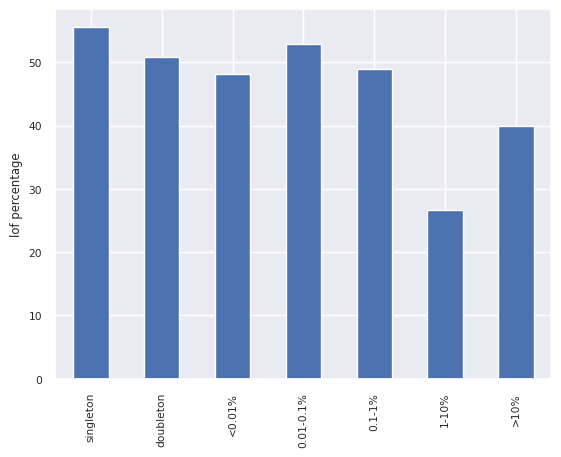

In [105]:
# plot percentage for each confidence group with PHYLOCSF_WEAK flag that is loss-of-function
(phylo_freq['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1].plot(kind='bar'))
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label

In [292]:
LC_phylo = (loftee.loc[(loftee['lof']=='LC')
                       &(loftee['flags'].isin(['unflagged','PHYLOCSF_WEAK']))
                       &(loftee['consequence'].isin(['frameshift_variant','stop_gained'])),:])
LC_phylo.groupby(['consequence','flags'])['BETA'].describe()

/var/tmp/ipykernel_7245/19576820.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LC_phylo.groupby(['consequence','flags'])['BETA'].describe()


count      mean       std      min  \
consequence        flags                                               
frameshift_variant unflagged      290.0 -0.914513  1.449338 -3.72461   
                   PHYLOCSF_WEAK  231.0 -0.845677  1.348828 -3.50693   
stop_gained        unflagged      225.0 -1.011910  1.414478 -4.04660   
                   PHYLOCSF_WEAK  180.0 -0.694723  1.484300 -4.40800   

                                       25%       50%       75%      max  
consequence        flags                                                 
frameshift_variant unflagged     -2.038460 -1.034755  0.044838  4.14319  
                   PHYLOCSF_WEAK -1.938270 -0.881075  0.049685  3.19156  
stop_gained        unflagged     -2.051770 -1.258760  0.001283  3.25141  
                   PHYLOCSF_WEAK -1.738865 -0.826418  0.151582  4.10219

In [293]:
LC_phylo['flags'] = pd.Categorical(LC_phylo['flags'], categories=['unflagged','PHYLOCSF_WEAK'], ordered=True)
LC_phylo_stop = LC_phylo.loc[LC_phylo['consequence']=='stop_gained',:].groupby('flags')
x = (LC_phylo_stop['loss_of_function']
 .value_counts(normalize=True)
 .mul(100)
 [:,1])
x

/var/tmp/ipykernel_7245/1069442737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LC_phylo['flags'] = pd.Categorical(LC_phylo['flags'], categories=['unflagged','PHYLOCSF_WEAK'], ordered=True)
/var/tmp/ipykernel_7245/1069442737.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LC_phylo_stop = LC_phylo.loc[LC_phylo['consequence']=='stop_gained',:].groupby('flags')


flags
unflagged        56.0
PHYLOCSF_WEAK    45.0
Name: proportion, dtype: float64

Text(0.5, 1.0, 'LC stop-gained')

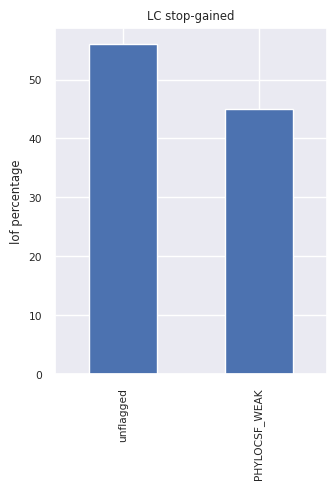

In [295]:
# plot percentage for each confidence group with PHYLOCSF_WEAK flag that is loss-of-function
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(3.5,4.5))
x.plot(kind='bar')
plt.gca().set_xlabel("") ## Set X-axis label
plt.gca().set_ylabel("lof percentage") ## Set Y-axis label
plt.title('LC stop-gained')

In [81]:
# export final QCed PTVs dataframe for easier use later
ptvs.to_csv('/home/jupyter/gcs/ukb/QC/ptvs_QC_final.txt', sep='\t', index=False)